In [42]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import os
import glob
import re
import sys
import pickle

from ipywidgets import interact, Dropdown

from photutils.aperture import CircularAperture, aperture_photometry
from spectral_cube import SpectralCube

from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from astropy.constants import c
from astropy.io import fits
from astropy.visualization import simple_norm, imshow_norm
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec
from astropy.nddata import block_reduce
from astropy.nddata import Cutout2D

home_directory = "/d/ret1/Taylor/jupyter_notebooks/Research" 
os.chdir(home_directory) #TJ change working directory to be the parent directory

from Py_files.Basic_analysis import * #TJ import basic functions from custom package
from Py_files.Convolution_script import * #TJ import convolution functions from custom package
from Py_files.All_flux_calibration_functions import *
with open("Data_files/misc_data/jwst_pivots.pkl", "rb") as file:
    jwst_pivots = pickle.load(file)
with open("Data_files/misc_data/jwst_filter_means.pkl", "rb") as file:
    jwst_means = pickle.load(file)

image_files, filter_files = generate_list_of_files()
v0p3_images, _ = generate_v0p3_files()
full_raw_ifu_files_loc0 = ['Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch1-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch2-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch3-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch4-shortmediumlong_s3d.fits']
full_raw_ifu_files_loc1 = ['Data_files/IFU_files/raw_IFUs/location_1/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_1/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_1/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_1/Arm2_Level3_ch1-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_1/Arm2_Level3_ch2-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_1/Arm2_Level3_ch3-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_1/Arm2_Level3_ch4-shortmediumlong_s3d.fits']
full_raw_ifu_files_loc3 = ['Data_files/IFU_files/raw_IFUs/location_3/jw03435-o006_t010_nirspec_g140m-f100lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_3/jw03435-o006_t010_nirspec_g235m-f170lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_3/jw03435-o006_t010_nirspec_g395m-f290lp_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_3/Arm3_Level3_ch1-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_3/Arm3_Level3_ch2-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_3/Arm3_Level3_ch3-shortmediumlong_s3d.fits',
              'Data_files/IFU_files/raw_IFUs/location_3/Arm3_Level3_ch4-shortmediumlong_s3d.fits']
#TJ this full_spectrum is built by stitching cube0 to cube1 anchored to cube1
#TJ then stitching cube2 to cube3 anchored to cube3, then stitching all the others unaltered
full_spec = 'Data_files/misc_data/Updated_flux_calibration/full_spectrum_loc0_rad1p25.npy'
locations = [[202.5062429, 47.2143358], [202.4335225, 47.1729608], [202.4340450, 47.1732517], [202.4823742, 47.1958589]]
radius = 1.25*u.arcsec


In [40]:
def raw_IFUs_with_coverage(filter_name):
    '''return which raw files are at least partially contained within this filter
    
    -------------
    
    Parameters
    -------------
    filter_name : type = string - upper case filter name

    Returns
    -------------
    list of raw ifu files
    '''   
    needed = []
    low, high = [x.value for x in get_filter_wl_range(filter_name)]
    for file in full_raw_ifu_files_loc0:
        wl = SpectralCube.read(file, hdu = 'SCI').spectral_axis.to(u.m).value
        if (wl[-1] >= low and wl[0] <= high):
            needed.append(file)
    return needed

def show_spec_and_all_filters(list_of_IFUs, list_of_photos, loc, radius, save_data = False):
    '''Plots spectrum and overplots the observed flux through filters within that spectrum's range.
    Loops through photo files, so feel free to include extraneous IFU files but do not include multiple photos of same filter
    This includes multiple convolutions of the same photo, just call the function again if that is the case.
    -------------
    
    Parameters
    -------------
    list_of_IFUs : type = list - list of IFU files to be stitched together and plotted
    list_of_photos : type = list - list of photo files from which to extract filter bandpass fluxes
    loc : type = either [ra, dec] in degrees, or a SkyCoord object - location of center of the aperture
    radius : type = angular size - radius of aperture, must have units attached.
    save_data (optional) : if provided, saves entire data output to a numpy file at the location provided
    
    Returns
    -------------
    If saving data, it returns the filepath to the data, otherwise Nothing, just plots.
    '''   
    spec_y_min = 1 #TJ Flux should always be around 10^-20 so setting limits of 0-1 should never be too strict
    spec_y_max = 0
    cmap = cm.get_cmap('rainbow', len(list_of_photos)) #TJ create colormap with enough colors to cover all the filters (1photo=1filter)
    colors = [cmap(i) for i in range(len(list_of_photos))]
    filter_names = [] #TJ initialize filters for x-axis
    y_data = [] #TJ initialize synth/photo array for y-axis
    for p, photo_file in enumerate(list_of_photos): #TJ loop through photos, since there will never be duplicates for this
        try:
            filter_name = extract_filter_name(photo_file) #TJ pull out filter name to be used for full loop
        except:
            print(f'filter name not identified in {photo_file.split("/")[-1]}')
        filter_names.append(filter_name) #TJ add filter name to x-axis
        filter_file = [flt for flt in filter_files if extract_filter_name(flt) == filter_name][0] #TJ grab the filter file for this filter
        filter_wl, filter_trans = get_filter_data(filter_name)
        filter_start, filter_end = [x.value for x in get_filter_wl_range(filter_name)] #TJ not necessary, but may be used for print statements
        
        photo_flux = get_image_flux(photo_file, loc, radius, replace_negatives = False) #TJ get aperture sum of photo flux
        
        filter_mean = jwst_means[filter_name].value #TJ record filter mean wavelength for color differentiation in plotting
        try: #TJ it is much faster to give this function an array rather than fits files, so if that was the case, do this.
            wavelength, flux = np.load(list_of_IFUs) 
            synth_flux = get_Fnu_transmission(flux, wavelength, filter_trans, filter_wl, warnings = True) #TJ apply filter transmission and aperture sum
            title = f"Full spectrum using numpy file {list_of_IFUs.split('/')[-1]}"
        except: #TJ if loading the numpy array fails for whatever reason, go through longer process
            #TJ first, check if these are raw IFU files identified by ending with s3d
            if len([file for file in list_of_IFUs if file.split('/')[-1].split('_')[-1] == "s3d.fits"]) > 0: 
                ifu_files = raw_IFUs_with_coverage(filter_name) #TJ grab all the raw files that have at least some coverage in filter
                title = 'Data from raw files'
            else:
                ifu_files = [file for file in list_of_IFUs if extract_filter_name(file) == filter_name]
                title = 'Data from modified files'
            #TJ if two files are needed
            ifu_data = stitch_spectra(ifu_files, loc, radius, replace_negatives = False)
            synth_flux = get_Fnu_transmission(ifu_data['intensity'], ifu_data['wavelength'], filter_trans, filter_wl, warnings = True)
            wavelength = ifu_data['wavelength']
            flux = ifu_data['intensity']
        y_data.append(synth_flux/photo_flux)
        plt.scatter(filter_mean, photo_flux, label = filter_name, marker = "*", color = colors[p])
        plt.scatter(filter_mean, synth_flux, marker = "o", color = colors[p])
        plt.plot(wavelength[(wavelength > filter_start) & (wavelength < filter_end)], flux[(wavelength > filter_start) & (wavelength < filter_end)], alpha = 0.5, color = colors[p])
        spec_y_min = min(spec_y_min, np.percentile(flux, 1)*0.5)
        spec_y_max = max(spec_y_max, np.percentile(flux, 98)*1.5)
    plt.scatter([], [], label = 'obs photo flux', marker = "*", color = 'black')
    plt.scatter([], [], label = 'synth photo flux', marker = "o", color = 'black')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(spec_y_min, spec_y_max)
    plt.xticks(rotation = 45)
    plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
    plt.title(title)
    plt.show()

    plt.scatter(filter_names, y_data, marker = "o", color = 'black')
    plt.axhline(y = 1, color = 'gray', linestyle = '--', linewidth = 1, alpha = 0.5)
    plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    plt.ylim(0.5,1.4)
    ymin, ymax = plt.ylim()
    text_y_pos = ymax * 0.94
    
    # Add NIRCam label to the left
    plt.text(15.25, text_y_pos, "← NIRCam", 
             ha='right', va='center', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
             fontsize=10)
    
    # Add MIRI label to the right
    plt.text(15.75, text_y_pos, "MIRI →", 
             ha='left', va='center', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
             fontsize=10)
    plt.xlabel('Filter Names')
    plt.ylabel('Synthetic image flux / actual image flux')
    plt.title("FLux transmitted through filter compared to spectrum-derived expectations \nNormalized to image-extracted values")
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()

def make_synthetic_image(ifu_file, filter_name, output_file=None,
                         real_image_file=None, loc=None, radius=None,
                         display=False, stretch='asinh'):
    """
    Create a synthetic image through a given filter from an IFU cube.
    
    Parameters
    ----------
    ifu_file : str
        Path to IFU FITS file (flux vs. wavelength, y, x).
    filter_name : str
        Name of the filter to apply.
    output_file : str, optional
        Name of output FITS file for the synthetic image.
    real_image_file : str, optional
        Path to real image file for side-by-side comparison.
    display : bool, optional
        If True, display the synthetic image (and real image if provided).
    filter_info : dict, optional
        Information needed by `Get_Fnu_transmission`.
    
    Returns
    -------
    hdu_out : fits.HDUList
        HDU list containing the synthetic image.
    """
    filter_file = []
    # Load IFU cube with SpectralCube
    cube = SpectralCube.read(ifu_file, hdu = "SCI")
    wl = cube.spectral_axis.to(u.m).value   # or 'angstrom' depending on your needs
    ny, nx = cube.shape[1:]  # cube.shape = (nchan, ny, nx)

    # Allocate synthetic image
    synthetic = np.zeros((ny, nx))
    filter_filepath = [flt for flt in filter_files if extract_filter_name(flt) == filter_name][0]
    filter_data = []
    with open(filter_filepath, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)
            
    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
    filter_trans = [try_float(filter_T[i,1]) for i in range(len(filter_T))]

    # Loop over spaxels
    for y in range(ny):
        for x in range(nx):
            flux = cube[:, y, x].value  # spectrum in native cube units
            synthetic[y, x] = get_Fnu_transmission(flux, wl,  filter_trans, filter_wl)

    # Build header (use 2D spatial WCS from cube)
    hdr2d = cube.wcs.celestial.to_header()
    hdu_out = fits.PrimaryHDU(synthetic, header=hdr2d)
    hdul_out = fits.HDUList([hdu_out])

    if output_file:
        hdul_out.writeto(output_file, overwrite=True)

    # Display if requested
    if display:
        # Choose stretch
        if stretch == 'asinh':
            stretch_func = AsinhStretch()
        elif stretch == 'log':
            stretch_func = LogStretch()
        else:
            raise ValueError("stretch must be 'asinh' or 'log'")

        fig, ax = plt.subplots(1, 2 if real_image_file else 1, figsize=(12, 6))

        # Show real image if provided
        if real_image_file:
            hdu_real = fits.open(real_image_file)['SCI']
            image_data = hdu_real.data
            image_wcs = WCS(hdu_real.header, naxis=2)

            ny, nx = synthetic.shape
            center = SkyCoord.from_pixel(nx/2, ny/2, ifu_wcs)
            cutout = Cutout2D(data=image_data, position=center,
                              size=(ny, nx), wcs=image_wcs)

            real_data = cutout.data
            real_wcs = cutout.wcs
            norm_real = ImageNormalize(real_data,
                                       stretch=stretch_func,
                                       vmin=0,
                                       vmax=np.percentile(real_data, 99))
            ax[0].imshow(real_data, origin='lower', cmap='viridis', norm=norm_real)
            ax[0].set_title("Real Image")

            # Synthetic image in the same figure
            norm_syn = ImageNormalize(synthetic,
                                      stretch=stretch_func,
                                      vmin=0,
                                      vmax=np.percentile(synthetic, 99))
            ax[1].imshow(synthetic, origin='lower', cmap='viridis', norm=norm_syn)
            ax[1].set_title(f"Synthetic {filter_name}")
        
        else:
            norm_syn = ImageNormalize(synthetic,
                                      stretch=stretch_func,
                                      vmin=0,
                                      vmax=np.percentile(synthetic, 99))
            ax.imshow(synthetic, origin='lower', cmap='viridis', norm=norm_syn)
            ax.set_title(f"Synthetic {filter_name}")

        plt.show()
    return hdul_out
def get_annulus_flux(image_file, location, radius, thickness):
    """Returns the total flux through the annulus centered at location, with outer radius and thickness from image file"""
    
    big_flux = get_image_flux(image_file, location, radius)
    little_flux = get_image_flux(image_file, location, u.arcsec*max((radius-thickness).value, 1e-6))
    return big_flux - little_flux
    
def make_radial_profile(image_files, location, thickness = 0.1*u.arcsec, max_radius = 2.5*u.arcsec, 
                        show_plot = True, bumps = False, show_image = 0):
    """Plots intensity within annulus vs annulus radius for all image files.

    """

    filter_names = [extract_filter_name(image_file) for image_file in image_files]
    if show_plot:
        
        fig = plt.figure(figsize = (45,30))
        fontsize_sm = 40
        fontsize_lg = 45
        ax_scatter = fig.add_axes((0.05, 0.05, 0.85, 0.85))
    for i, file in enumerate(image_files):
        if i < 8:
            marker = '*'
        elif i < 15:
            marker = 'o'
        else:
            marker = 'x'
        
        annulus_flux = []
        annulus_radius = []
        annulus_area = []
        annulus_intensity = []
        effective_radius = None
        for r1 in np.linspace(thickness.value, max_radius.value, 49):
            out_radius = r1*u.arcsec
            flux = get_annulus_flux(file, location, out_radius, thickness)
            area = (np.pi*(((r1**2 - (r1-thickness.value)**2)*u.deg**2).to(u.sr))).value
            annulus_flux.append(flux)
            annulus_radius.append((out_radius - (thickness/2)).value)
            annulus_area.append(area)
            annulus_intensity.append(flux/area)

        annulus_flux = np.array(annulus_flux)
        annulus_radius = np.array(annulus_radius)
        annulus_area = np.array(annulus_area)
        annulus_intensity = np.array(annulus_intensity)
    
        ax_scatter.scatter(annulus_radius, annulus_intensity, label=f'{extract_filter_name(file)}', marker = marker, s = 75)
    colors = ['red', 'black', 'blue']
    if len(bumps)>3:
        print('only three apertures can be shown in the image, additional apertures discarded')
    for i, bump in enumerate(bumps):
        if i > 2:
            break
        bump_inner = (bump - (thickness/2)).value 
        bump_outer = (bump + (thickness/2)).value 
        ax_scatter.axvline(x=bump_inner, linestyle = '--', color = colors[i])
        ax_scatter.axvline(x=bump_outer, linestyle = '--', color = colors[i])

    ax_scatter.tick_params(axis='x', which='minor', width=2, length=10, right=True, top=True, direction='in',
                       labelsize=fontsize_sm)
    ax_scatter.tick_params(axis='x', which='major', width=3, length=15, right=True, top=True, direction='in',
                       labelsize=fontsize_sm)
    ax_scatter.tick_params(axis='y', which='both', width=3, length=15, right=True, top=True, direction='in',
                       labelsize=fontsize_sm)
    ax_scatter.set_yscale('log')
    ax_scatter.set_xlabel('Aperture radius (arcseconds)', fontsize = 40)
    ax_scatter.set_ylabel('Aperture intensity (MJy/sr)', fontsize = 40)
    ax_scatter.set_title(f'{thickness}-wide annular intensity vs radius', fontsize = 50)

    fig.legend(loc='upper left', bbox_to_anchor=(0.9, 0.85), fontsize = 60)
    
    #image plot
    image_file = image_files[show_image]
    hdu = fits.open(image_file)['SCI']
    image = hdu.data
    image_header = hdu.header
    image_wcs = WCS(image_header, naxis=2)
    pixel_scale = np.abs(image_wcs.wcs.cdelt[0]) * 3600  # arcsec/pixel

    loc_sky = SkyCoord(ra=location[0]*u.deg, dec=location[1]*u.deg, frame='icrs')
    cutout = Cutout2D(data = image, position = loc_sky, size = (max_radius*2, max_radius*2), wcs = image_wcs)
    ax_image = fig.add_axes((0.57, 0.5, 0.4, 0.4), projection = cutout.wcs)
    ax_image.set_title('F115W image with bump apertures', fontsize = 30)
    x_img, y_img = cutout.wcs.all_world2pix(loc_sky.ra, loc_sky.dec, 0)
    ax_image.imshow(cutout.data, origin='lower', cmap='viridis',
                          norm=ImageNormalize(cutout.data, stretch=AsinhStretch(), vmin=0, vmax=np.percentile(cutout.data, 99)))
    for i, bump in enumerate(bumps):    
        bump_pix_inner = (bump-(thickness/2)).to(u.arcsec).value / pixel_scale
        bump_pix_outer = (bump+(thickness/2)).to(u.arcsec).value / pixel_scale
        
        ax_image.add_patch(Circle((x_img, y_img), bump_pix_inner, ec=colors[i], fc='none', lw=3, ls='-', alpha = 0.7))
        ax_image.add_patch(Circle((x_img, y_img), bump_pix_outer, ec=colors[i], fc='none', lw=3, ls='-', alpha = 0.7))

    plt.show()
    return [annulus_radius, annulus_intensity]
    
    #plt.scatter(filter_names, falloff, marker = 'x')
    #plt.xlabel('filter name')
    #plt.ylabel('radius where intensity is 50% maximum')
    #plt.title(f'location {l+1}:\ncomparing falloff rate of annular intensity')
    #plt.xticks(rotation = 45)
    #plt.show()

loc0_photo_fluxes = []
loc0_photo_wls = []
photo_filter_names = []
for photo in image_files:
    filter_name = extract_filter_name(photo)
    photo_filter_names.append(filter_name)
    loc0_photo_wls.append(jwst_means[filter_name].value)
    loc0_photo_fluxes.append(get_image_flux(photo, locations[0], radius, replace_negatives = False))
loc1_photo_fluxes = []
loc1_photo_wls = []
for photo in image_files:
    filter_name = extract_filter_name(photo)
    loc1_photo_wls.append(jwst_means[filter_name].value)
    loc1_photo_fluxes.append(get_image_flux(photo, locations[1], radius, replace_negatives = False))
loc2_photo_fluxes = []
loc2_photo_wls = []
for photo in image_files:
    filter_name = extract_filter_name(photo)
    loc2_photo_wls.append(jwst_means[filter_name].value)
    loc2_photo_fluxes.append(get_image_flux(photo, locations[2], radius, replace_negatives = False))
loc3_photo_fluxes = []
loc3_photo_wls = []
for photo in image_files:
    filter_name = extract_filter_name(photo)
    loc3_photo_wls.append(jwst_means[filter_name].value)
    loc3_photo_fluxes.append(get_image_flux(photo, locations[3], radius, replace_negatives = False))


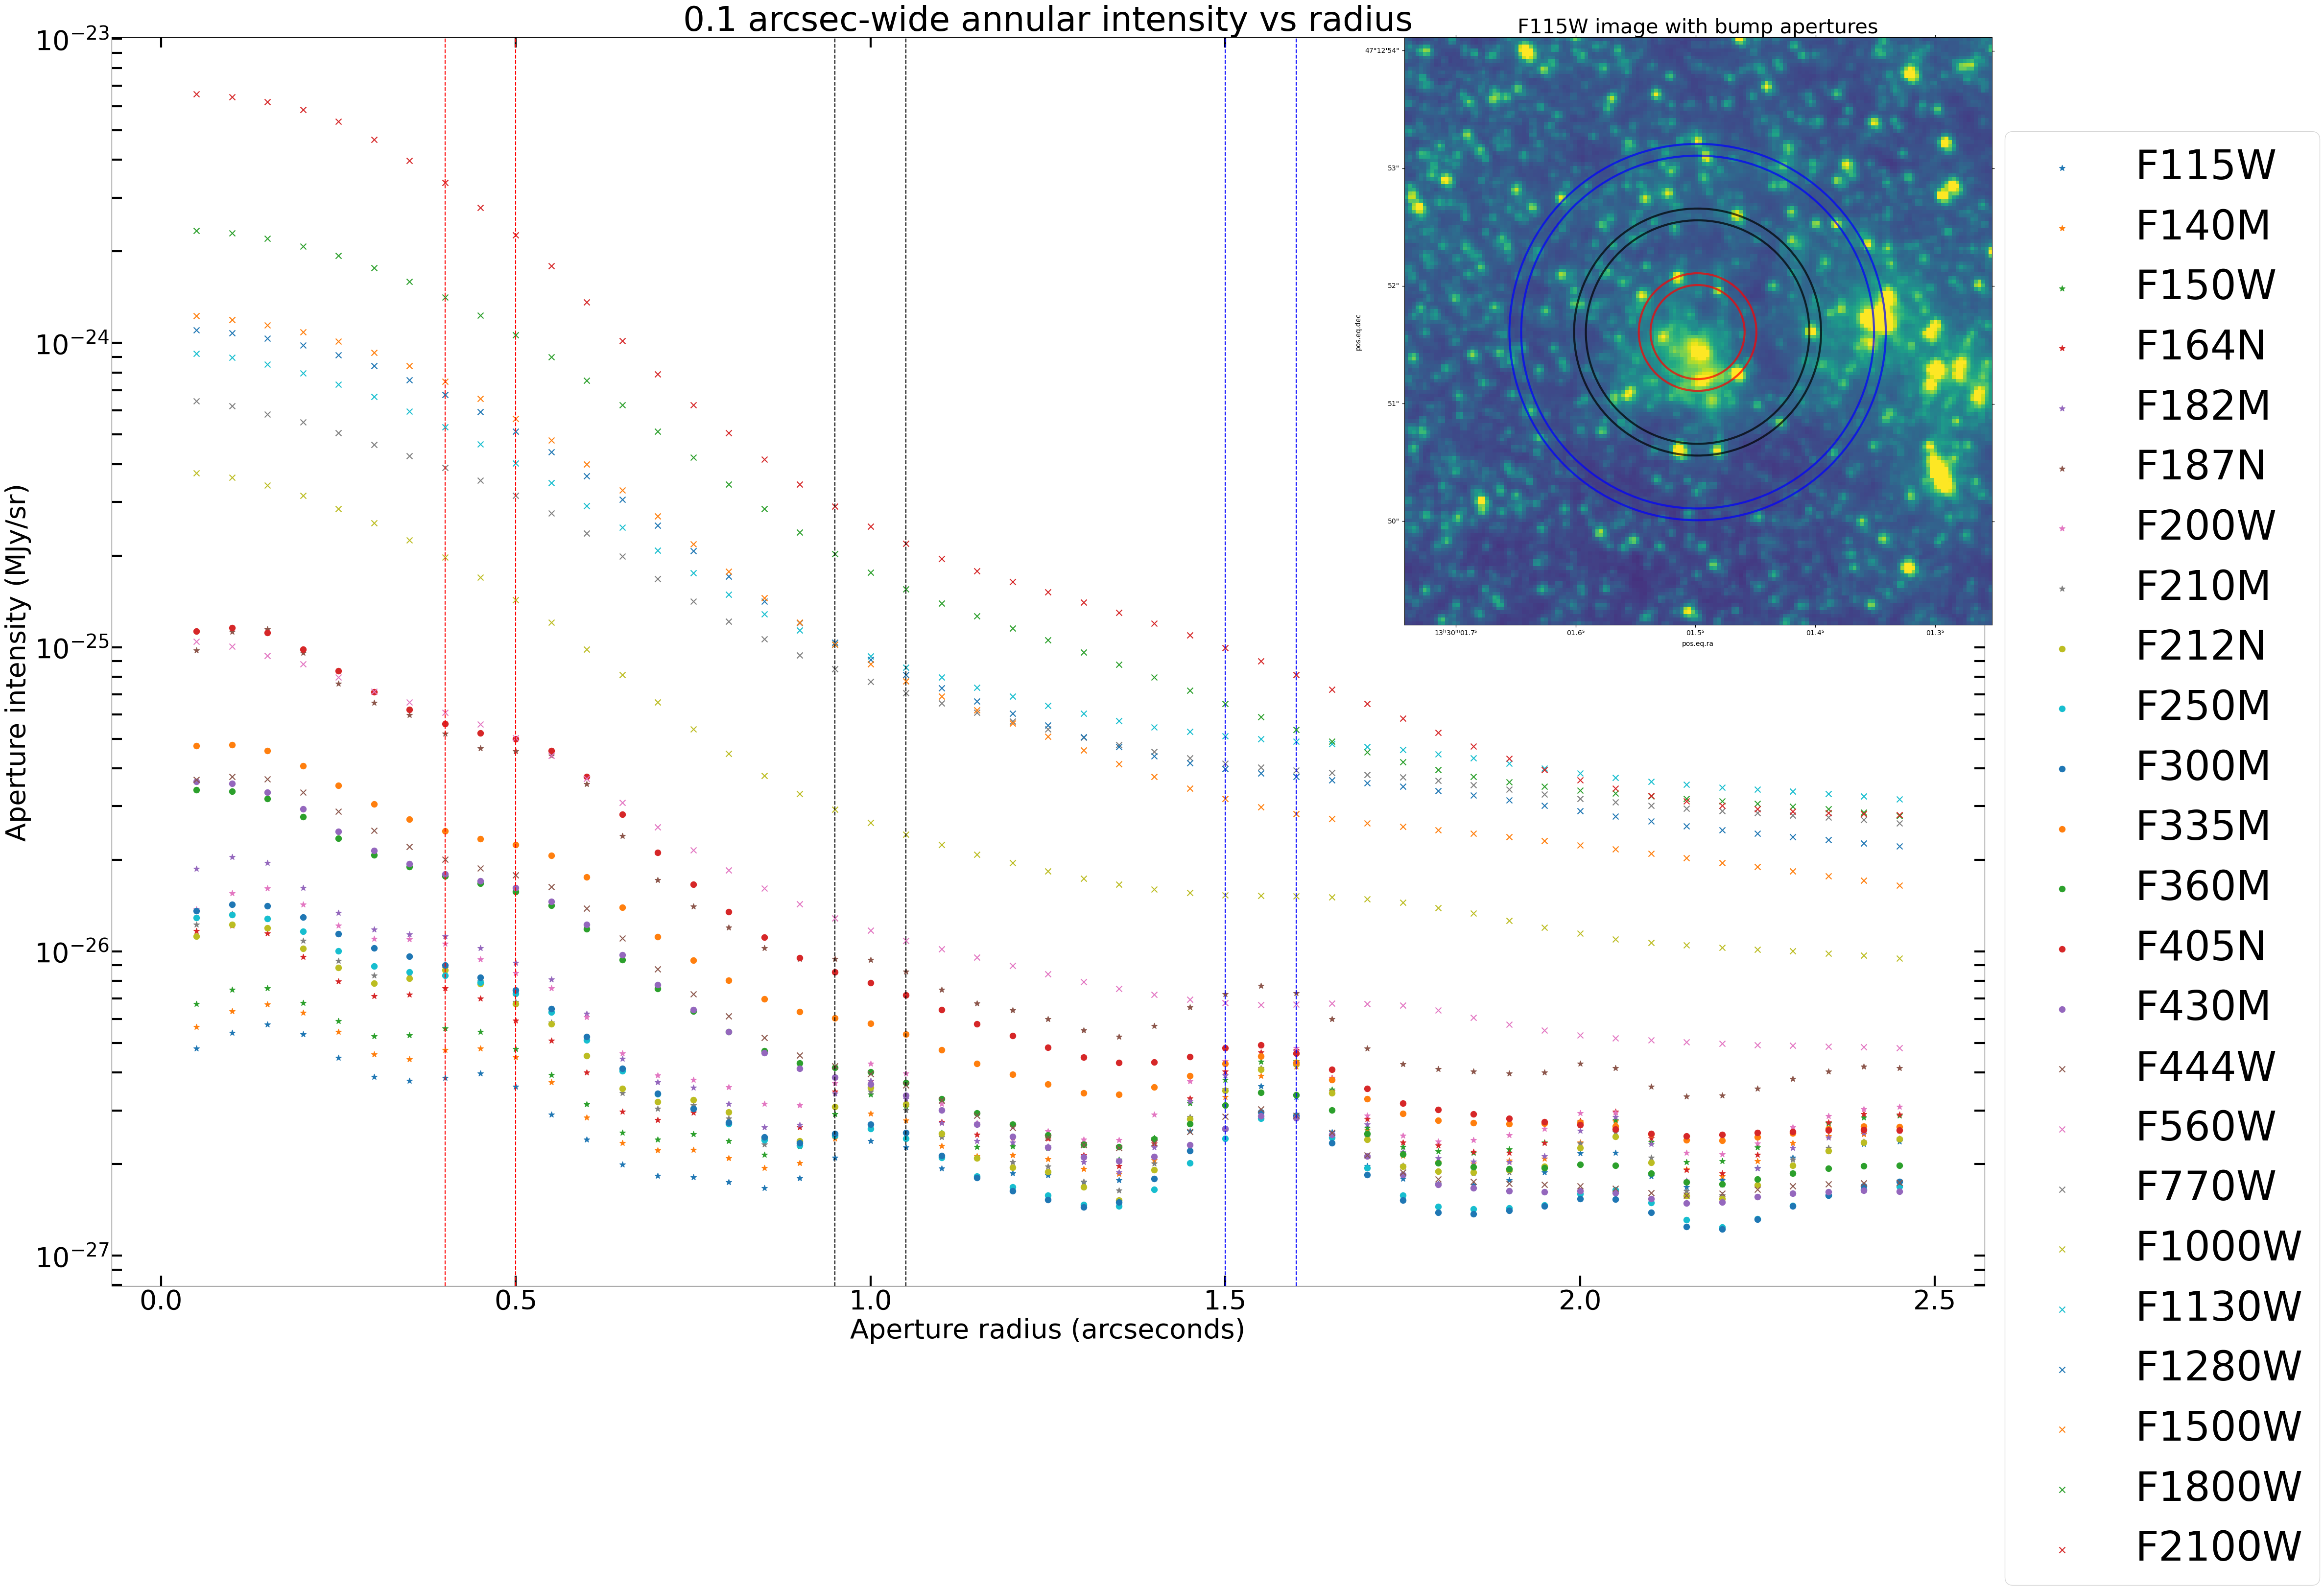

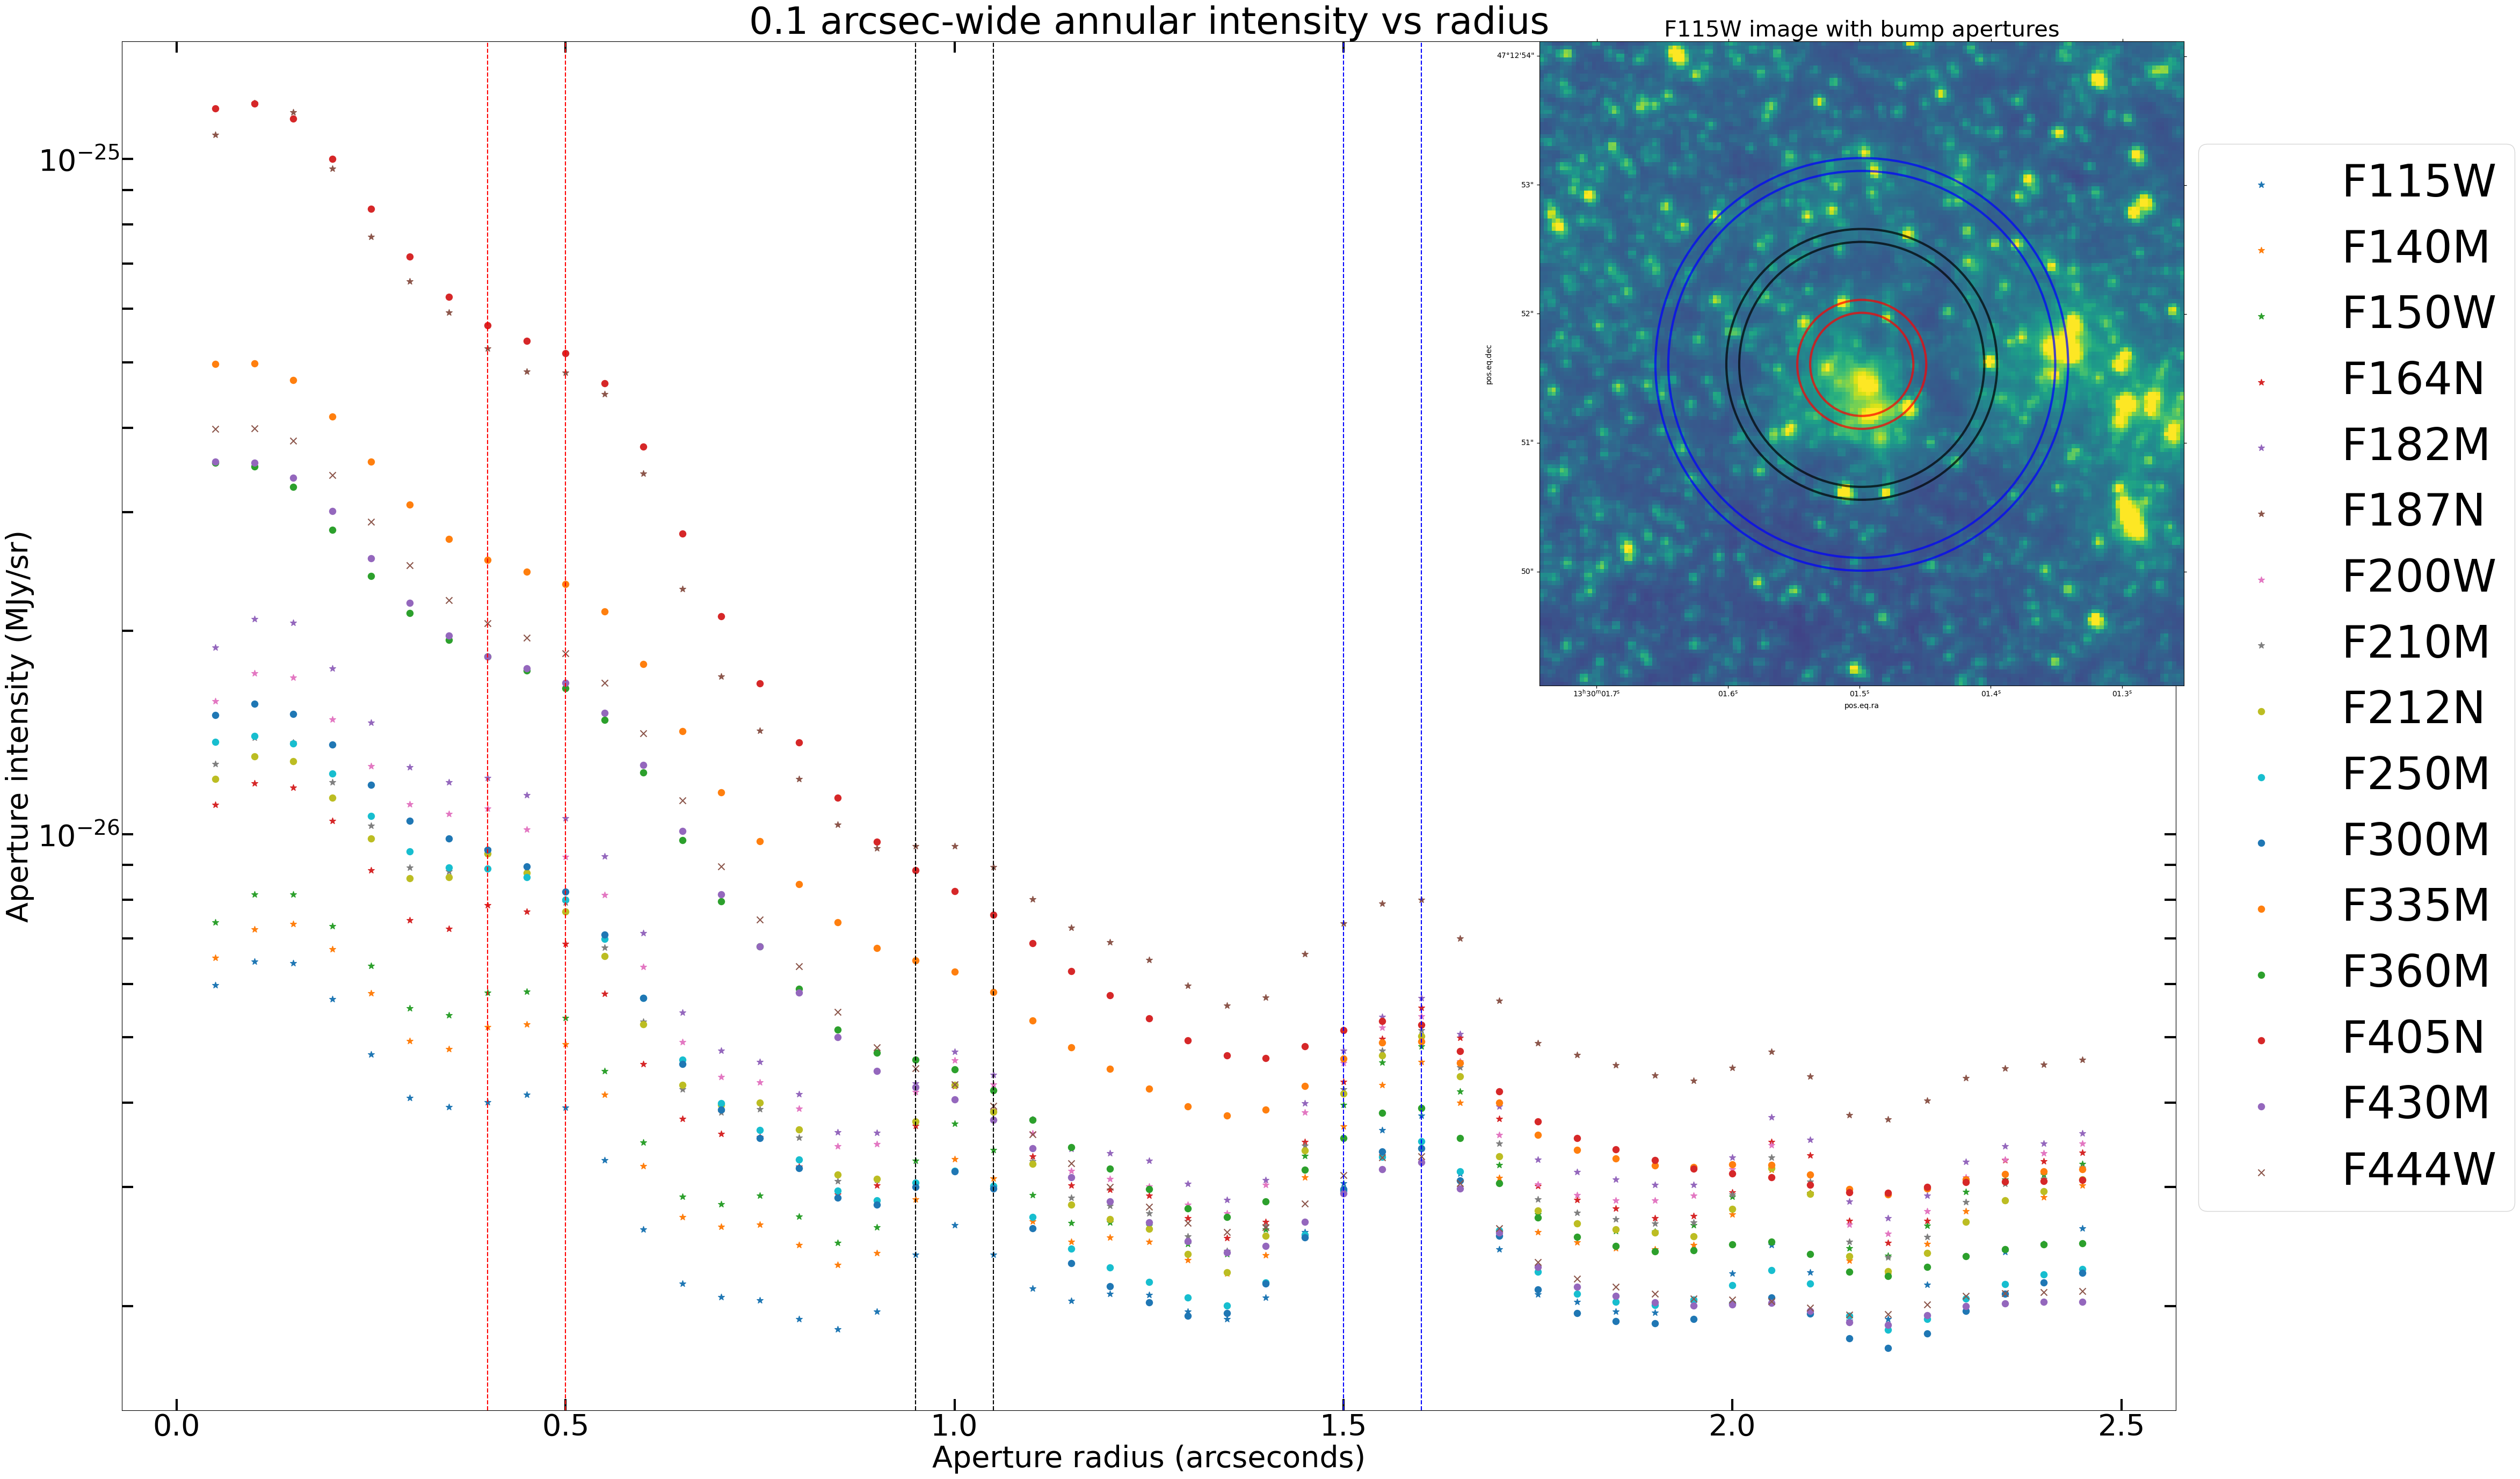

[array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
        1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65,
        1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15, 2.2 ,
        2.25, 2.3 , 2.35, 2.4 , 2.45]),
 array([3.98151596e-26, 3.98992505e-26, 3.82734916e-26, 3.39865460e-26,
        2.89973833e-26, 2.50203405e-26, 2.22142828e-26, 2.05141134e-26,
        1.95422418e-26, 1.85198576e-26, 1.67501628e-26, 1.41125798e-26,
        1.12243604e-26, 8.94888040e-27, 7.46518446e-27, 6.36629000e-27,
        5.45364609e-27, 4.83089360e-27, 4.50074969e-27, 4.26110300e-27,
        3.95963223e-27, 3.59039326e-27, 3.25320319e-27, 3.00305416e-27,
        2.80681347e-27, 2.65368533e-27, 2.57134397e-27, 2.61467790e-27,
        2.83466133e-27, 3.12567442e-27, 3.32054005e-27, 3.33057378e-27,
        3.04087840e-27, 2.60844638e-27, 2.32263862e-27, 2.19484454e-27,
        2.133679

In [41]:
make_radial_profile(image_files, locations[0], thickness = 0.1*u.arcsec, max_radius = 2.5*u.arcsec, show_plot = True, bumps = [0.45, 1, 1.55]*u.arcsec)
make_radial_profile(v0p3_images, locations[0], thickness = 0.1*u.arcsec, max_radius = 2.5*u.arcsec, show_plot = True, bumps = [0.45, 1, 1.55]*u.arcsec)

A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 1.8899740453634867e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 1.8899740453634867e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Stitching RIGHT: anchor → file 1
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Stitching RIGHT: anchor → file 1
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
A 

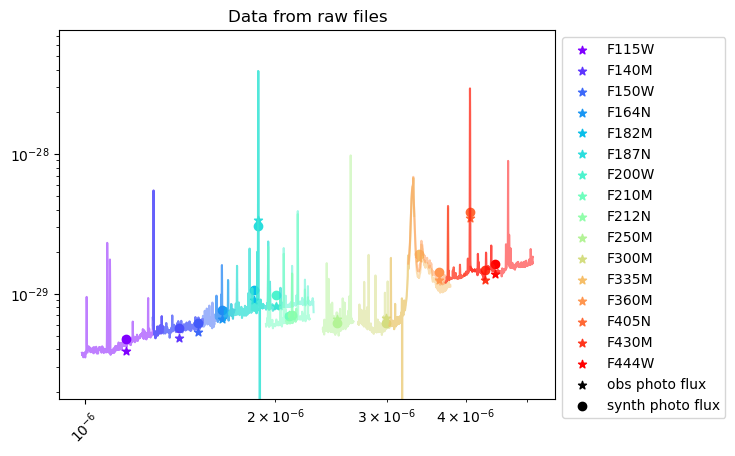

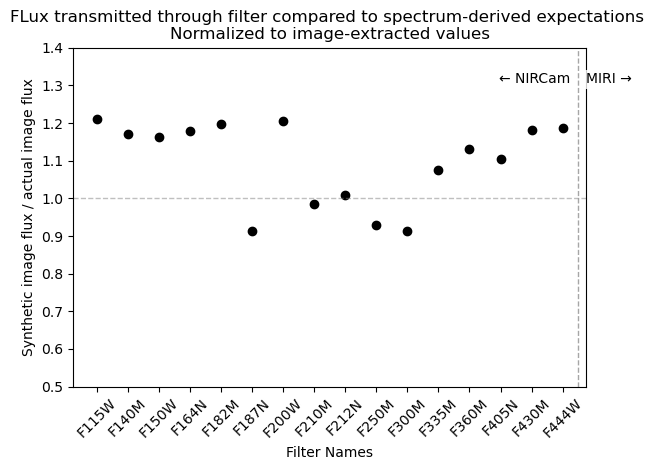

In [20]:
show_spec_and_all_filters(full_raw_ifu_files_loc0, v0p3_images, locations[0], radius)


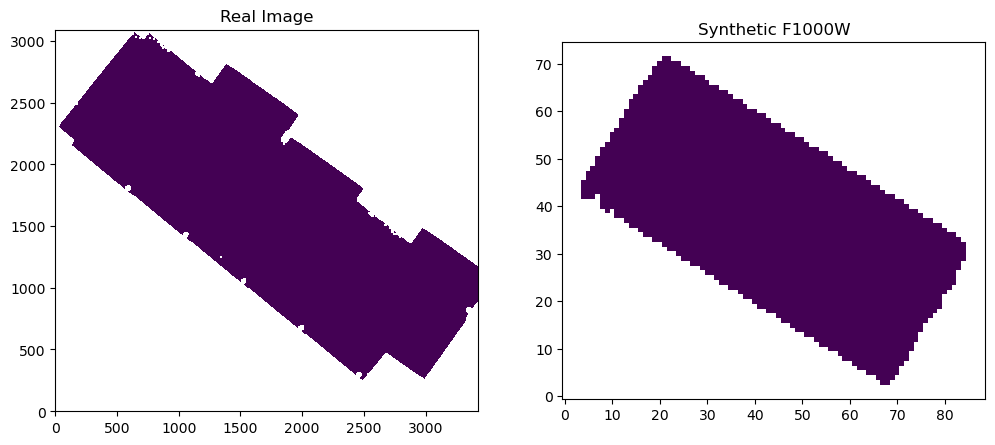

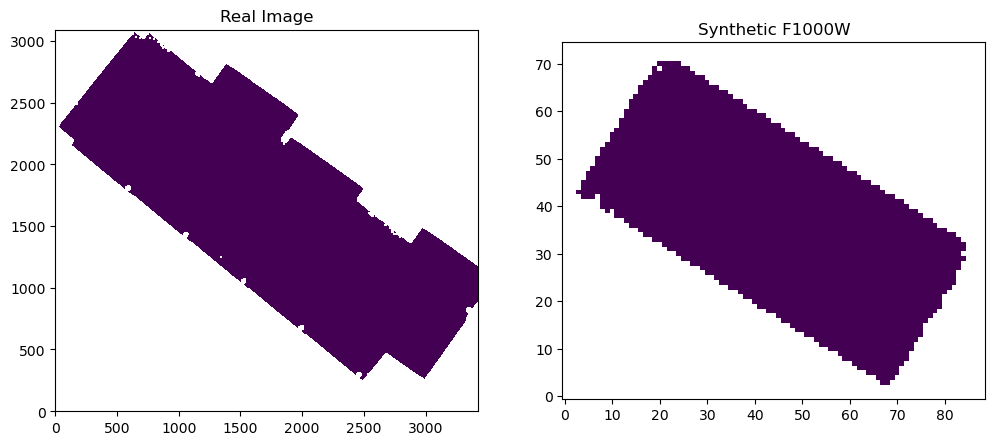

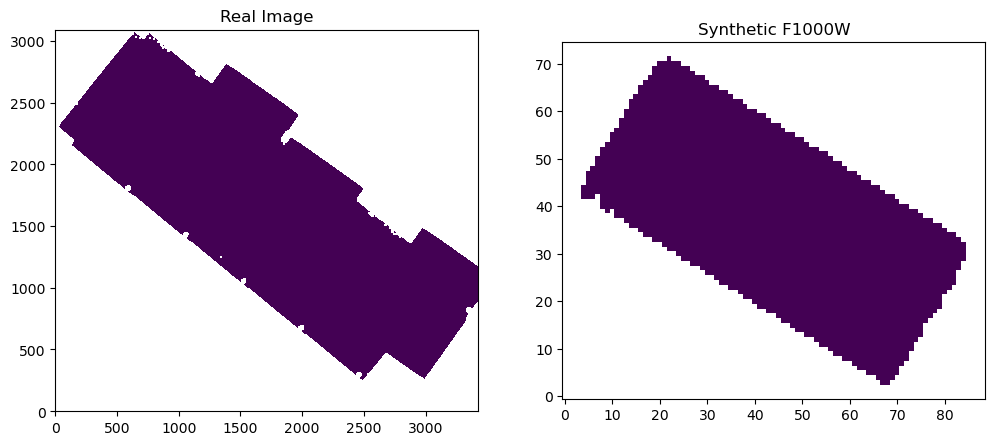

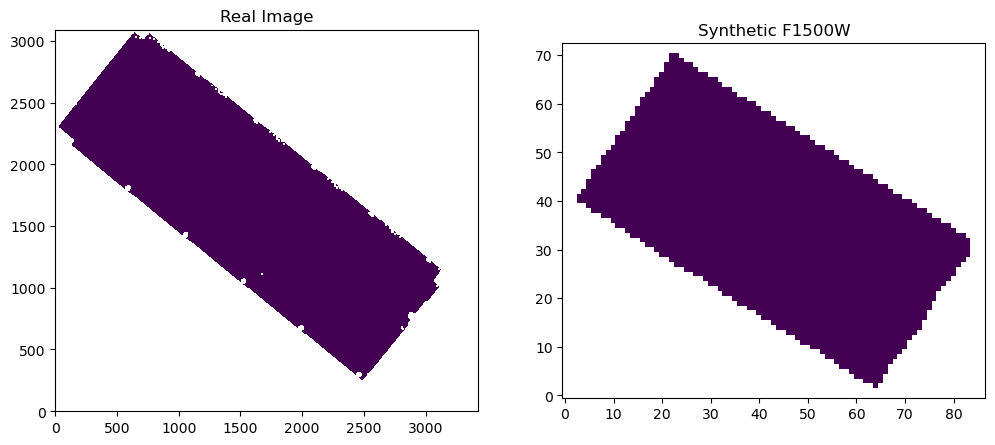

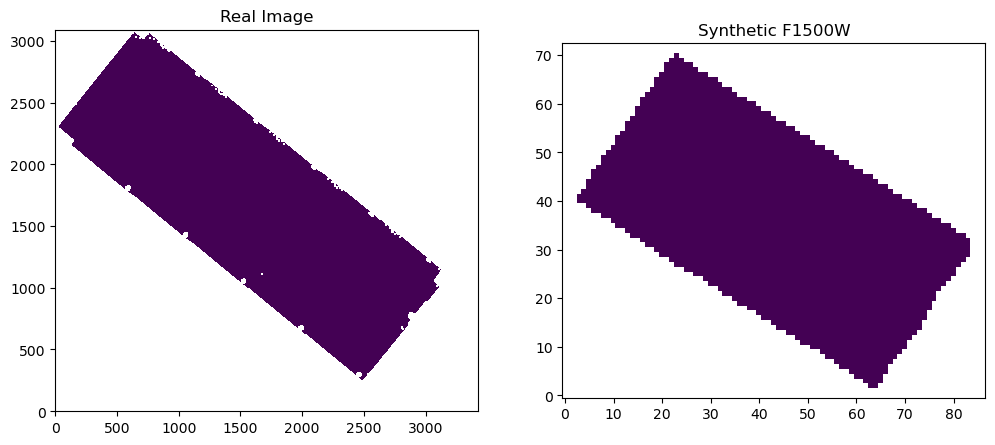

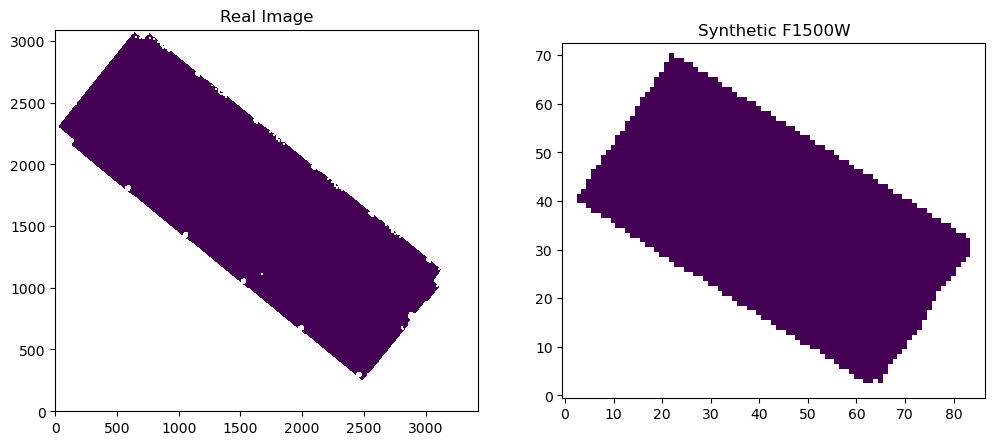

filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter g

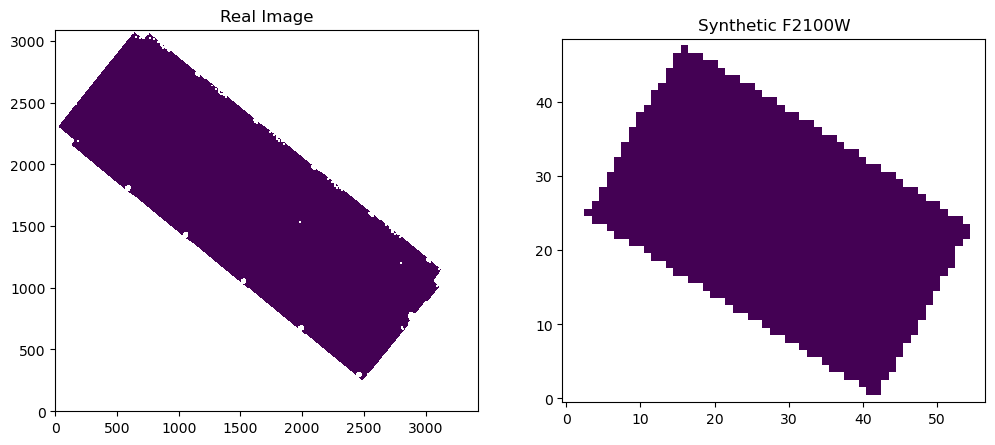

filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter g

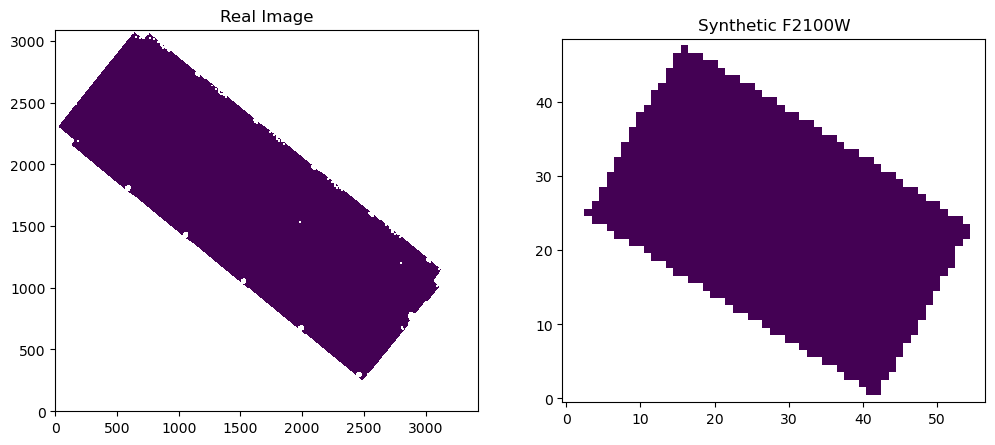

filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter goes from 1.7141e-05 to 2.5575e-05, but provided Fnu array goes from 1.770300076296553e-05 to 2.8701000858563927e-05
filter g

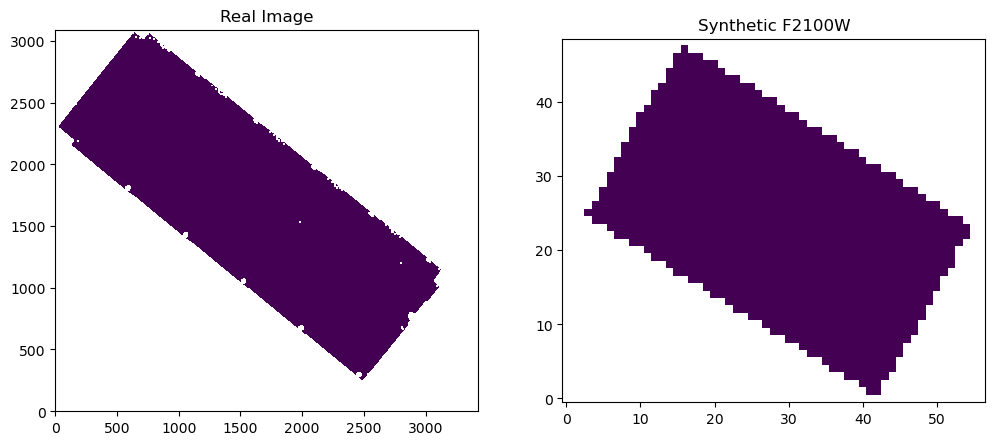

In [45]:
make_synthetic_image(full_raw_ifu_files_loc0[4], 'F1000W', output_file='Data_files/Synthetic_loc0_F1000W.fits', real_image_file=image_files[-6], loc=locations[0], 
                         display=True, stretch='asinh')
make_synthetic_image(full_raw_ifu_files_loc1[4], 'F1000W', output_file='Data_files/Synthetic_loc1_F1000W.fits', real_image_file=image_files[-6], loc=locations[1], 
                         display=True, stretch='asinh')
make_synthetic_image(full_raw_ifu_files_loc3[4], 'F1000W', output_file='Data_files/Synthetic_loc3_F1000W.fits', real_image_file=image_files[-6], loc=locations[3], 
                         display=True, stretch='asinh')
make_synthetic_image(full_raw_ifu_files_loc0[5], 'F1500W', output_file='Data_files/Synthetic_loc0_F1500W.fits', real_image_file=image_files[-3], loc=locations[0], 
                         display=True, stretch='asinh')
make_synthetic_image(full_raw_ifu_files_loc1[5], 'F1500W', output_file='Data_files/Synthetic_loc1_F1500W.fits', real_image_file=image_files[-3], loc=locations[1], 
                         display=True, stretch='asinh')
make_synthetic_image(full_raw_ifu_files_loc3[5], 'F1500W', output_file='Data_files/Synthetic_loc3_F1500W.fits', real_image_file=image_files[-3], loc=locations[3], 
                         display=True, stretch='asinh')
make_synthetic_image(full_raw_ifu_files_loc0[6], 'F2100W', output_file='Data_files/Synthetic_loc0_F2100W.fits', real_image_file=image_files[-1], loc=locations[0], 
                         display=True, stretch='asinh')
make_synthetic_image(full_raw_ifu_files_loc1[6], 'F2100W', output_file='Data_files/Synthetic_loc1_F2100W.fits', real_image_file=image_files[-1], loc=locations[1], 
                         display=True, stretch='asinh')
make_synthetic_image(full_raw_ifu_files_loc3[6], 'F2100W', output_file='Data_files/Synthetic_loc3_F2100W.fits', real_image_file=image_files[-1], loc=locations[3], 
                         display=True, stretch='asinh')

In [32]:
image_files

array(['Data_files/Image_files/ngc5194_nircam_lv3_f115w_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f140m_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f150w_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f164n_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f182m_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f187n_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f200w_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f210m_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f212n_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f250m_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f300m_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f335m_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f360m_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f405n_i2d.fits',
       'Data_files/Image_files/ngc5194_nircam_lv3_f430m_i2d.fi

A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 1.8899740453634867e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 1.8899740453634867e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Stitching RIGHT: anchor → file 1
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Stitching RIGHT: anchor → file 1
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
A 

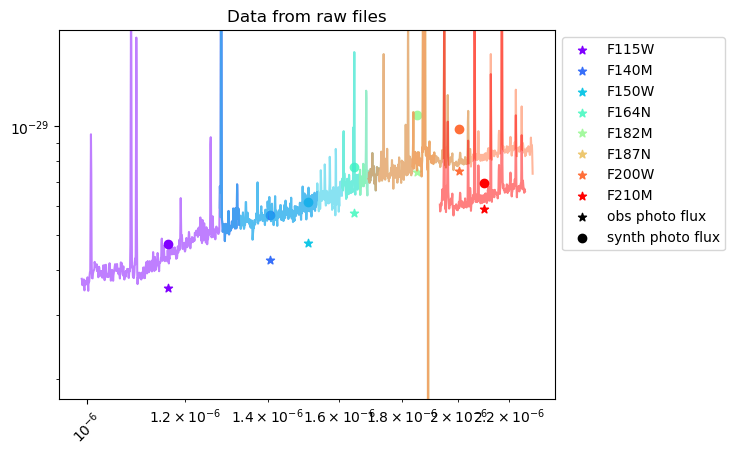

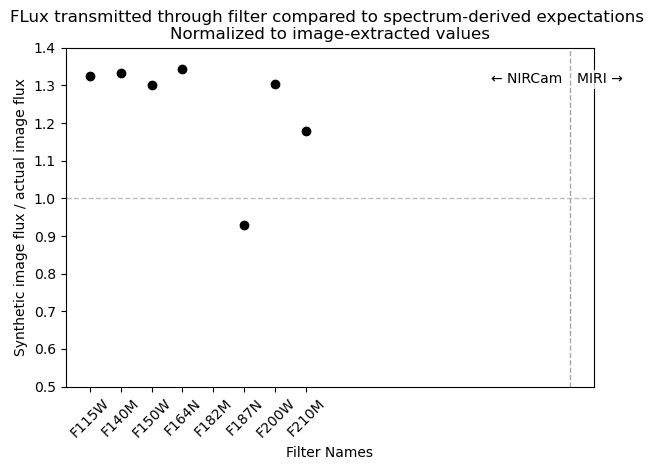

A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 1.6605299666407517e-06 -- 3.169970021757762e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 1.6605299666407517e-06 -- 3.169970021757762e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Stitching RIGHT: anchor → file 1
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Combined spectrum: 1.6605299666407517e-06 -- 5.269494898093397e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Stitching RIGHT: anchor → file 1
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Combined spectrum: 1.6605299666407517e-06 -- 5.269494898093397e-06


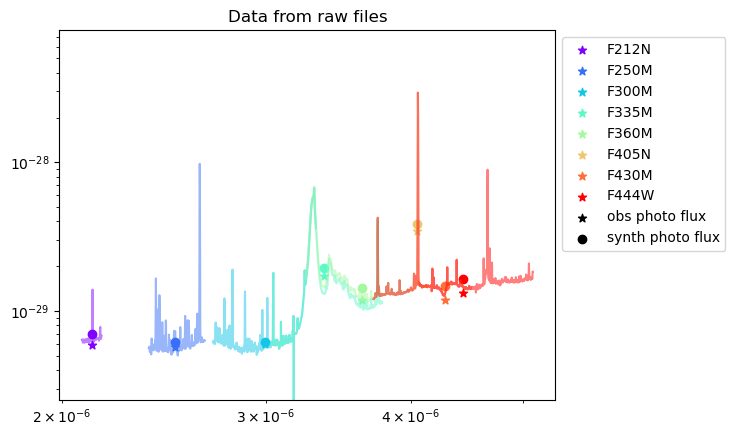

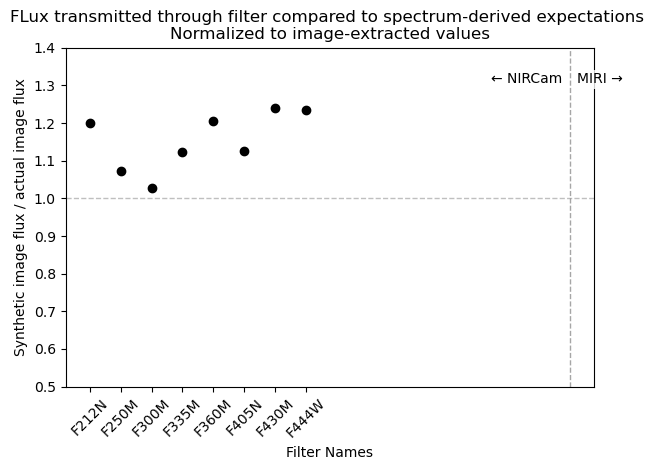

A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Stitching RIGHT: anchor → file 1
Combined spectrum: 2.870894885563757e-06 -- 7.650000025896587e-06
Stitching RIGHT: anchor → file 1
Combined spectrum: 4.9004000953573265e-06 -- 1.1700550240289882e-05
Combined spectrum: 7.5106502288836055e-06 -- 1.1700550240289882e-05
Stitching RIGHT: anchor → file 1
Combined spectrum: 7.5106502288836055e-06 -- 1.79787500470411e-05
Stitching RIGHT: anchor → file 1
Combined spectrum: 7.5106502288836055e-06 -- 1.79787500470411e-05
Combined spectrum: 1.1551250190706922e-05 -- 1.79787500470411e-05
Stitching RIGHT: anchor → file 1
A total of 13 were detected within 1.25 arcsec in Arm1_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs
Combined spectrum: 1.1551250190706922e-05 -- 2.870100085856393e-05
Stitching RIGHT: anchor → file 1
A total of 13 were detected within 1.25 arcsec in Arm1_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs
Combined spect

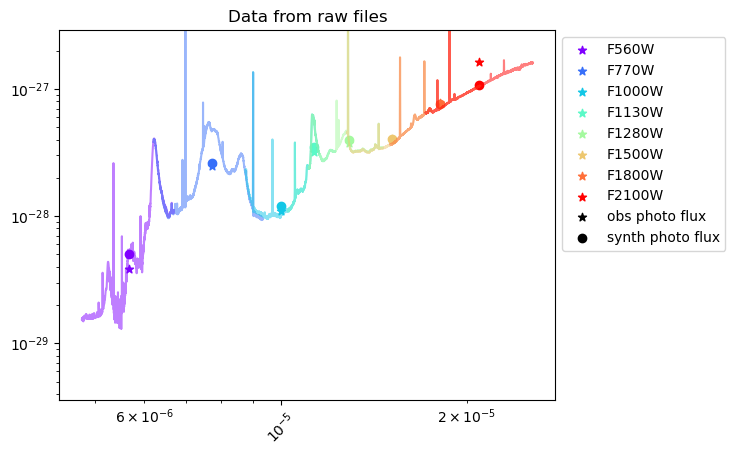

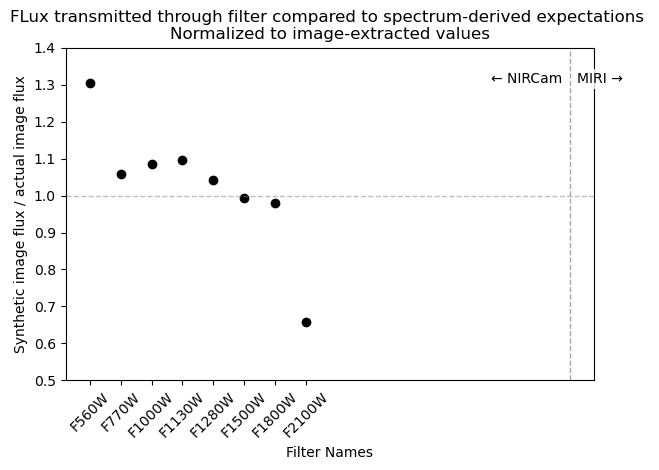

In [3]:
#This appears to show 
show_spec_and_all_filters(full_raw_ifu_files_loc0, image_files[:8], locations[0], radius)
show_spec_and_all_filters(full_raw_ifu_files_loc0, image_files[8:16], locations[0], radius)
show_spec_and_all_filters(full_raw_ifu_files_loc0, image_files[16:24], locations[0], radius)

In [65]:
get_filter_wl_range('F187N')

(<Quantity 1.8342e-06 m>, <Quantity 1.9132e-06 m>)

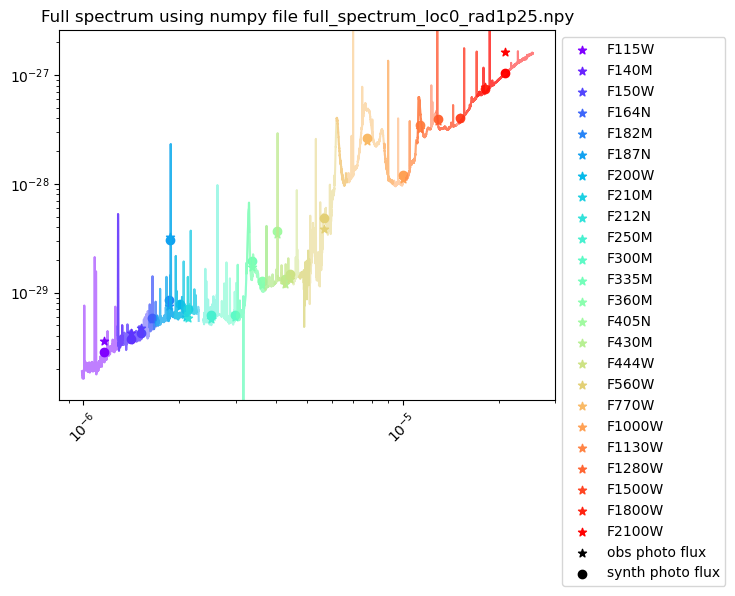

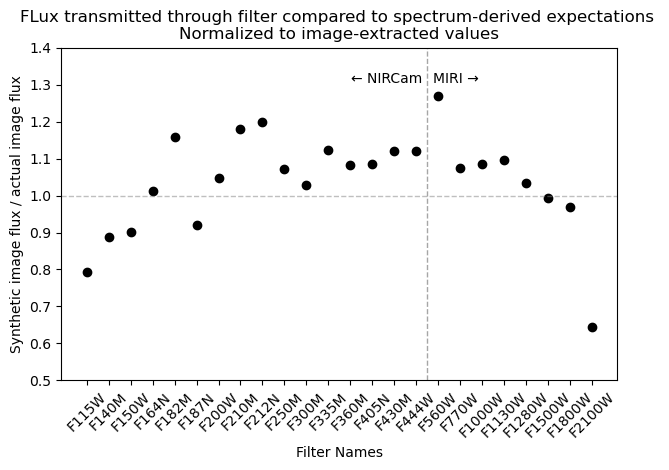

In [4]:
show_spec_and_all_filters(full_spec, image_files, locations[0], radius)

In [5]:
full_wl = []
full_flux = []
files = full_raw_ifu_files_loc1
loc = locations[1]
for i, raw_ifu in enumerate(files):
    if i == 0:
        data = stitch_spectra(files[i:i+2], loc, radius, replace_negatives = False, anchor_idx = 1)
        full_wl.append(data['wavelength'])
        full_flux.append(data['intensity'])
        continue
    if i == 1:
        continue
    if i == 2:
        data = stitch_spectra(files[i:i+2], loc, radius, replace_negatives = False, anchor_idx = 1)
        full_flux = np.concatenate([full_flux[0], data['intensity'][data['wavelength'] > full_wl[0][-1]]])
        full_wl = np.concatenate([full_wl[0], data['wavelength'][data['wavelength'] > full_wl[0][-1]]])
        continue
    if i == 3:
        continue
    if i == 4:
        data = stitch_spectra([files[i]], loc, radius, replace_negatives = False)
        full_flux = np.concatenate([full_flux, data['intensity'][data['wavelength'] > full_wl[-1]]])
        full_wl = np.concatenate([full_wl, data['wavelength'][data['wavelength'] > full_wl[-1]]])
        
        continue
    if i == 5:
        data = stitch_spectra([files[i]], loc, radius, replace_negatives = False)
        full_flux = np.concatenate([full_flux, data['intensity'][data['wavelength'] > full_wl[-1]]])
        full_wl = np.concatenate([full_wl, data['wavelength'][data['wavelength'] > full_wl[-1]]])
        continue
    if i == 6:
        data = stitch_spectra([files[i]], loc, radius, replace_negatives = False)
        full_flux = np.concatenate([full_flux, data['intensity'][data['wavelength'] > full_wl[-1]]])
        full_wl = np.concatenate([full_wl, data['wavelength'][data['wavelength'] > full_wl[-1]]])


A total of 1425 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Stitching LEFT: file 0 → anchor
A total of 1447 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
Stitching LEFT: file 0 → anchor
A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Combined spectrum: 2.870894885563757e-06 -- 7.650000025896587e-06
Combined spectrum: 7.5106502288836055e-06 -- 1.1700550240289882e-05
Combined spectrum: 1.1551250190706922e-05 -- 1.79787500470411e-05
A total of 13 were detected within 1.25 arcsec in Arm2_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs
Combined spectrum: 1.770300076296553e-05 -- 2.870100085856393e-05


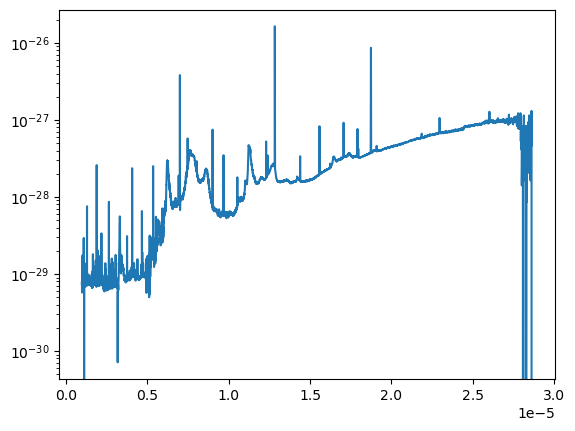

In [6]:
plt.plot(full_wl, full_flux)
plt.yscale('log')

A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Stitching RIGHT: anchor → file 1
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 9.703180286160204e-07 to 3.169970021757762e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Stitching LEFT: file 0 → anchor
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 9.703180286160204e-07 to 3.169970021757762e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits over 1447 WL

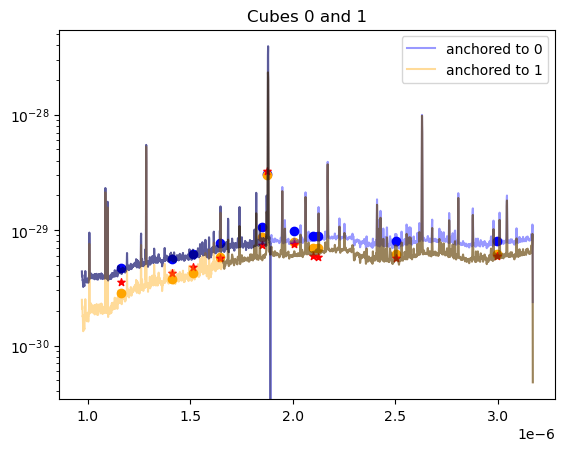

A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Stitching RIGHT: anchor → file 1
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Combined spectrum: 1.6605299666407517e-06 -- 5.269494898093397e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Stitching LEFT: file 0 → anchor
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 1.6605299666407517e-06 -- 5.269494898093397e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits over 1341 WLs


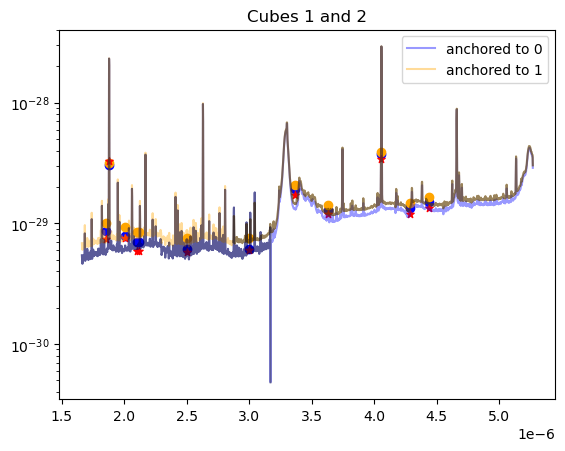

A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Stitching RIGHT: anchor → file 1
Combined spectrum: 2.870894885563757e-06 -- 7.650000025896587e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 2.870894885563757e-06 to 7.650000025896587e-06
Stitching LEFT: file 0 → anchor
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Combined spectrum: 2.870894885563757e-06 -- 7.650000025896587e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 2.870894885563757e-06 to 7.650000025896587e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits over 1341 WLs


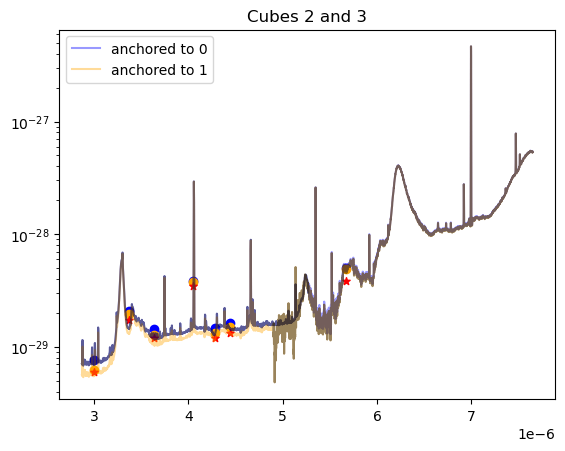

Stitching RIGHT: anchor → file 1
Combined spectrum: 4.9004000953573265e-06 -- 1.1700550240289882e-05
filter goes from 4.753e-06 to 6.696e-06, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05
filter goes from 1.0251e-05 to 1.2229000000000001e-05, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05
Stitching LEFT: file 0 → anchor
Combined spectrum: 4.9004000953573265e-06 -- 1.1700550240289882e-05
filter goes from 4.753e-06 to 6.696e-06, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05
filter goes from 1.0251e-05 to 1.2229000000000001e-05, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05


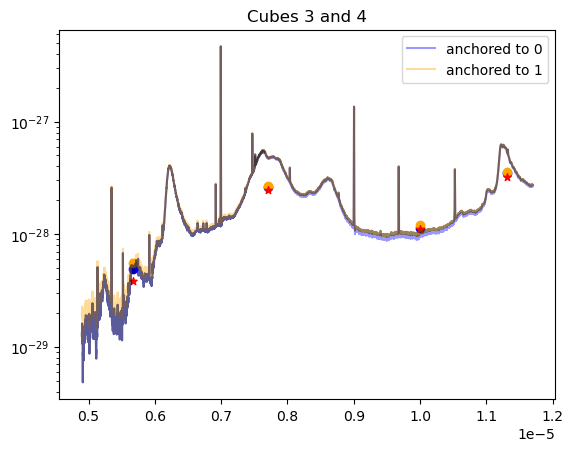

Stitching RIGHT: anchor → file 1
Combined spectrum: 7.5106502288836055e-06 -- 1.79787500470411e-05
filter goes from 6.2080000000000005e-06 to 9.329e-06, but provided Fnu array goes from 7.5106502288836055e-06 to 1.79787500470411e-05
Stitching LEFT: file 0 → anchor
Combined spectrum: 7.5106502288836055e-06 -- 1.79787500470411e-05
filter goes from 6.2080000000000005e-06 to 9.329e-06, but provided Fnu array goes from 7.5106502288836055e-06 to 1.79787500470411e-05


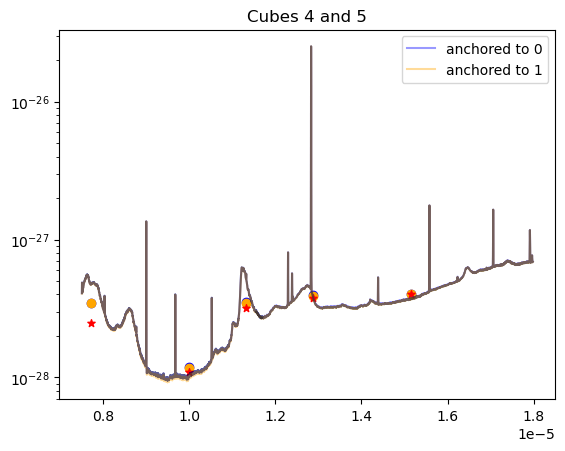

Stitching RIGHT: anchor → file 1
A total of 13 were detected within 1.25 arcsec in Arm1_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs
Combined spectrum: 1.1551250190706922e-05 -- 2.870100085856393e-05
filter goes from 1.1086e-05 to 1.4613e-05, but provided Fnu array goes from 1.1551250190706922e-05 to 2.870100085856393e-05
A total of 13 were detected within 1.25 arcsec in Arm1_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs
Stitching LEFT: file 0 → anchor
Combined spectrum: 1.1551250190706922e-05 -- 2.870100085856393e-05
filter goes from 1.1086e-05 to 1.4613e-05, but provided Fnu array goes from 1.1551250190706922e-05 to 2.870100085856393e-05
A total of 13 were detected within 1.25 arcsec in Arm1_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs


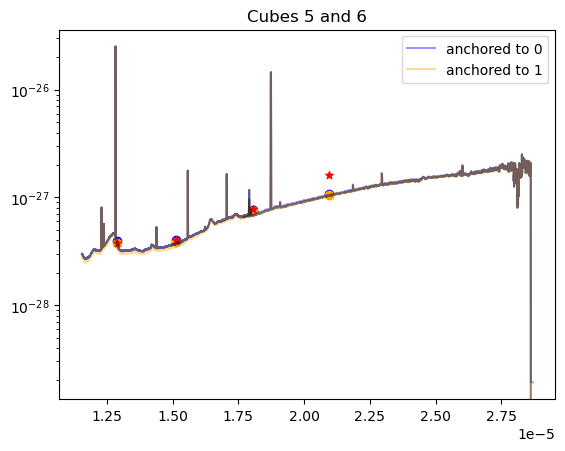

In [7]:
#Comparing adjacent cubes for location 0
for idx in range(6):
    loc = locations[0]
    files = full_raw_ifu_files_loc0
    phot_wl = loc0_photo_wls
    phot_flux = loc0_photo_fluxes
    data = stitch_spectra(files[idx:idx+2], loc, radius, replace_negatives = False, anchor_idx = 0)
    plt.plot(data['wavelength'], data['intensity'], alpha = 0.4, color = 'blue', label = 'anchored to 0')
    min_wl = min(data['wavelength'])
    max_wl = max(data['wavelength'])
    photo_indices = [i for i, x in enumerate(phot_wl) if min_wl < x < max_wl]
    photo_x = [phot_wl[i] for i in photo_indices]
    synth_y = []
    for filter_name in [photo_filter_names[i] for i in photo_indices]:
        filter_wl, filter_trans = get_filter_data(filter_name)
        synth_y.append(get_Fnu_transmission(data['intensity'], data['wavelength'], filter_trans, filter_wl, warnings = True))

    photo_y = np.array([phot_flux[x] for x in range(len(phot_flux)) if (min_wl < phot_wl[x] < max_wl)])
    synth_y = np.array(synth_y)
    

    plt.scatter(photo_x, synth_y, marker = 'o', color = 'blue')
    data = stitch_spectra(files[idx:idx+2], loc, radius, replace_negatives = False, anchor_idx = 1)
    plt.plot(data['wavelength'], data['intensity'], alpha = 0.4, color = 'orange', label = 'anchored to 1')
    synth_y = []
    for filter_name in [photo_filter_names[i] for i in photo_indices]:
        filter_wl, filter_trans = get_filter_data(filter_name)
        synth_y.append(get_Fnu_transmission(data['intensity'], data['wavelength'], filter_trans, filter_wl, warnings = True))

    synth_y = np.array(synth_y)
    plt.scatter(photo_x, synth_y, marker = 'o', color = 'orange')

    data = get_IFU_spectrum(files[idx], loc, radius)
    plt.plot(data['wavelength'], data['intensity'], color = 'black', alpha = 0.4)
    
    
    data = get_IFU_spectrum(files[idx+1], loc, radius)
    plt.plot(data['wavelength'], data['intensity'], color = 'black', alpha = 0.4)
    plt.scatter(photo_x, photo_y, marker = "*", color = 'red', s = 30)

    plt.yscale('log')
    plt.legend()
    plt.title(f'Cubes {idx} and {idx+1}')
    plt.show()


A total of 1447 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Stitching RIGHT: anchor → file 1
A total of 1425 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 9.703180286160204e-07 to 3.169970021757762e-06
A total of 1425 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Stitching LEFT: file 0 → anchor
A total of 1447 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 9.703180286160204e-07 to 3.169970021757762e-06
A total of 1447 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fi

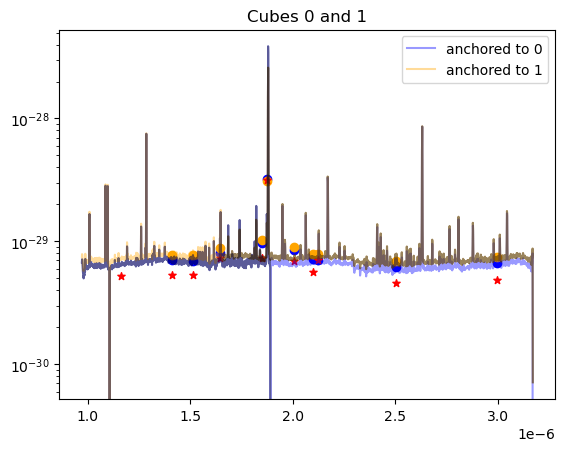

A total of 1425 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Stitching RIGHT: anchor → file 1
A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Combined spectrum: 1.6605299666407517e-06 -- 5.269494898093397e-06
A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Stitching LEFT: file 0 → anchor
A total of 1425 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 1.6605299666407517e-06 -- 5.269494898093397e-06
A total of 1425 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits over 1341 WLs


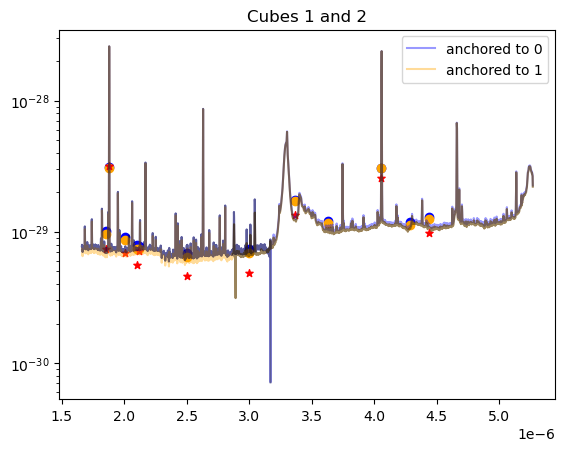

A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Stitching RIGHT: anchor → file 1
Combined spectrum: 2.870894885563757e-06 -- 7.650000025896587e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 2.870894885563757e-06 to 7.650000025896587e-06
Stitching LEFT: file 0 → anchor
A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Combined spectrum: 2.870894885563757e-06 -- 7.650000025896587e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 2.870894885563757e-06 to 7.650000025896587e-06
A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits over 1341 WLs


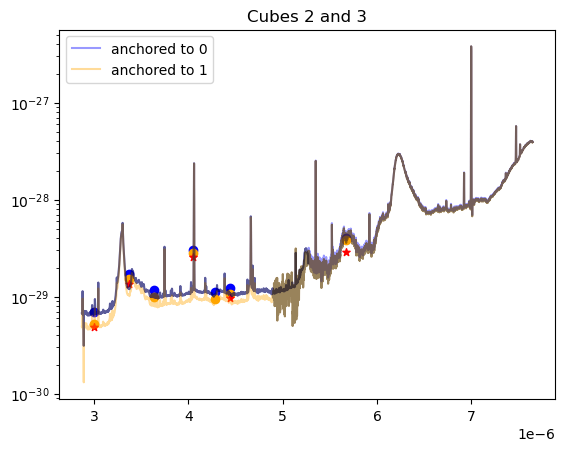

Stitching RIGHT: anchor → file 1
Combined spectrum: 4.9004000953573265e-06 -- 1.1700550240289882e-05
filter goes from 4.753e-06 to 6.696e-06, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05
filter goes from 1.0251e-05 to 1.2229000000000001e-05, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05
Stitching LEFT: file 0 → anchor
Combined spectrum: 4.9004000953573265e-06 -- 1.1700550240289882e-05
filter goes from 4.753e-06 to 6.696e-06, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05
filter goes from 1.0251e-05 to 1.2229000000000001e-05, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05


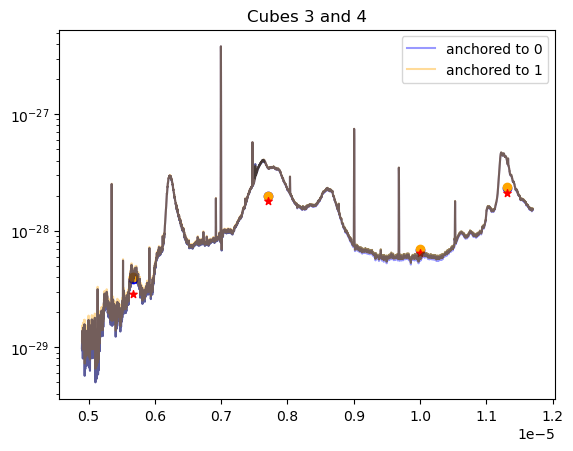

Stitching RIGHT: anchor → file 1
Combined spectrum: 7.5106502288836055e-06 -- 1.79787500470411e-05
filter goes from 6.2080000000000005e-06 to 9.329e-06, but provided Fnu array goes from 7.5106502288836055e-06 to 1.79787500470411e-05
Stitching LEFT: file 0 → anchor
Combined spectrum: 7.5106502288836055e-06 -- 1.79787500470411e-05
filter goes from 6.2080000000000005e-06 to 9.329e-06, but provided Fnu array goes from 7.5106502288836055e-06 to 1.79787500470411e-05


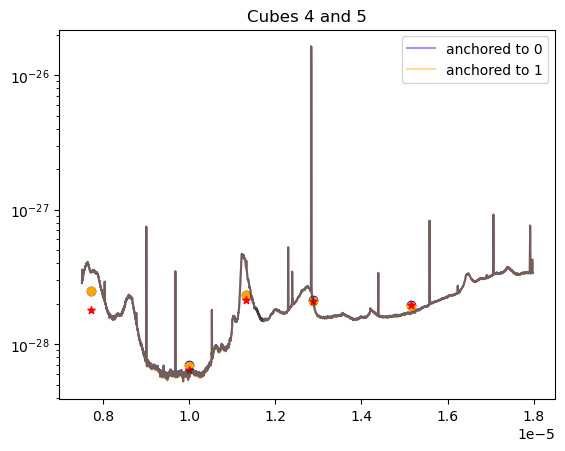

Stitching RIGHT: anchor → file 1
A total of 13 were detected within 1.25 arcsec in Arm2_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs
Combined spectrum: 1.1551250190706922e-05 -- 2.870100085856393e-05
filter goes from 1.1086e-05 to 1.4613e-05, but provided Fnu array goes from 1.1551250190706922e-05 to 2.870100085856393e-05
A total of 13 were detected within 1.25 arcsec in Arm2_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs
Stitching LEFT: file 0 → anchor
Combined spectrum: 1.1551250190706922e-05 -- 2.870100085856393e-05
filter goes from 1.1086e-05 to 1.4613e-05, but provided Fnu array goes from 1.1551250190706922e-05 to 2.870100085856393e-05
A total of 13 were detected within 1.25 arcsec in Arm2_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs


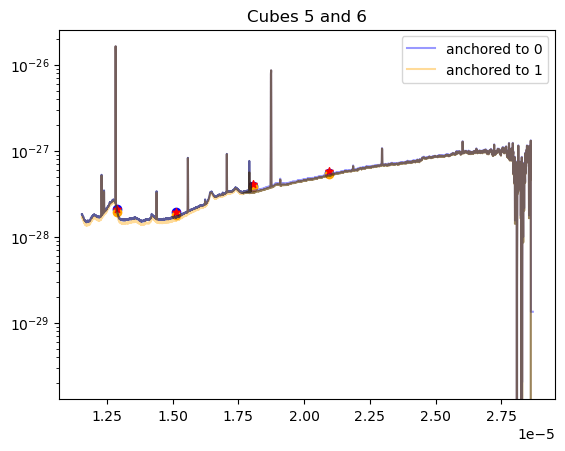

In [8]:
#Comparing adjacent cubes for location 1

for idx in range(6):
    loc = locations[1]
    files = full_raw_ifu_files_loc1
    phot_wl = loc1_photo_wls
    phot_flux = loc1_photo_fluxes
    data = stitch_spectra(files[idx:idx+2], loc, radius, replace_negatives = False, anchor_idx = 0)
    plt.plot(data['wavelength'], data['intensity'], alpha = 0.4, color = 'blue', label = 'anchored to 0')
    min_wl = min(data['wavelength'])
    max_wl = max(data['wavelength'])
    photo_indices = [i for i, x in enumerate(phot_wl) if min_wl < x < max_wl]
    photo_x = [phot_wl[i] for i in photo_indices]
    synth_y = []
    for filter_name in [photo_filter_names[i] for i in photo_indices]:
        filter_wl, filter_trans = get_filter_data(filter_name)
        synth_y.append(get_Fnu_transmission(data['intensity'], data['wavelength'], filter_trans, filter_wl, warnings = True))

    photo_y = np.array([phot_flux[x] for x in range(len(phot_flux)) if (min_wl < phot_wl[x] < max_wl)])
    synth_y = np.array(synth_y)
    

    plt.scatter(photo_x, synth_y, marker = 'o', color = 'blue')
    data = stitch_spectra(files[idx:idx+2], loc, radius, replace_negatives = False, anchor_idx = 1)
    plt.plot(data['wavelength'], data['intensity'], alpha = 0.4, color = 'orange', label = 'anchored to 1')
    synth_y = []
    for filter_name in [photo_filter_names[i] for i in photo_indices]:
        filter_wl, filter_trans = get_filter_data(filter_name)
        synth_y.append(get_Fnu_transmission(data['intensity'], data['wavelength'], filter_trans, filter_wl, warnings = True))

    synth_y = np.array(synth_y)
    plt.scatter(photo_x, synth_y, marker = 'o', color = 'orange')

    data = get_IFU_spectrum(files[idx], loc, radius)
    plt.plot(data['wavelength'], data['intensity'], color = 'black', alpha = 0.4)
    
    
    data = get_IFU_spectrum(files[idx+1], loc, radius)
    plt.plot(data['wavelength'], data['intensity'], color = 'black', alpha = 0.4)
    plt.scatter(photo_x, photo_y, marker = "*", color = 'red', s = 30)

    plt.yscale('log')
    plt.legend()
    plt.title(f'Cubes {idx} and {idx+1}')
    plt.show()


A total of 1447 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Stitching RIGHT: anchor → file 1
A total of 1425 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 9.703180286160204e-07 to 3.169970021757762e-06
A total of 1425 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Stitching LEFT: file 0 → anchor
A total of 1447 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 9.703180286160204e-07 to 3.169970021757762e-06
A total of 1447 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fi

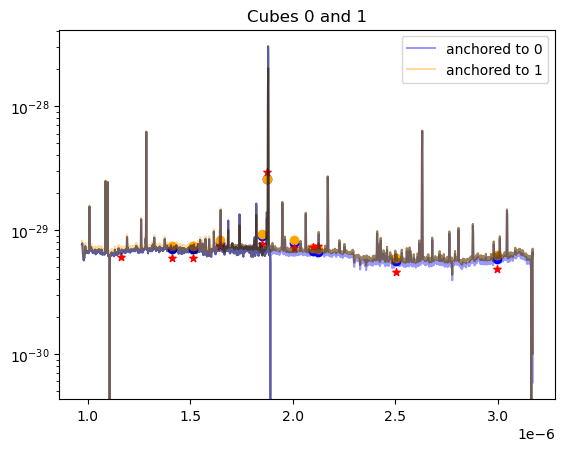

A total of 1425 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Stitching RIGHT: anchor → file 1
A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Combined spectrum: 1.6605299666407517e-06 -- 5.269494898093397e-06
A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Stitching LEFT: file 0 → anchor
A total of 1425 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 1.6605299666407517e-06 -- 5.269494898093397e-06
A total of 1425 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits over 1341 WLs


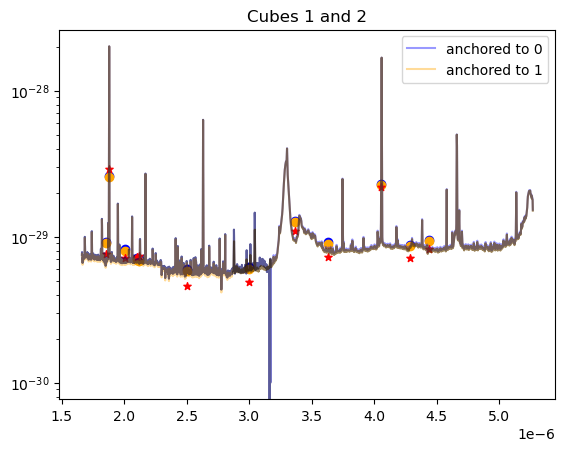

A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Stitching RIGHT: anchor → file 1
Combined spectrum: 2.870894885563757e-06 -- 7.650000025896587e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 2.870894885563757e-06 to 7.650000025896587e-06
Stitching LEFT: file 0 → anchor
A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Combined spectrum: 2.870894885563757e-06 -- 7.650000025896587e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 2.870894885563757e-06 to 7.650000025896587e-06
A total of 1341 were detected within 1.25 arcsec in jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits over 1341 WLs


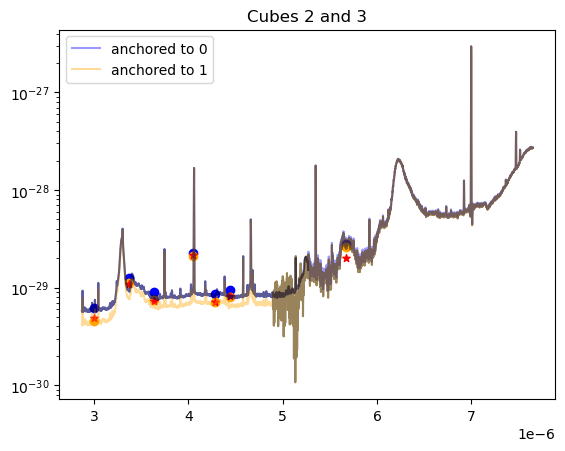

Stitching RIGHT: anchor → file 1
Combined spectrum: 4.9004000953573265e-06 -- 1.1700550240289882e-05
filter goes from 4.753e-06 to 6.696e-06, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05
filter goes from 1.0251e-05 to 1.2229000000000001e-05, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05
Stitching LEFT: file 0 → anchor
Combined spectrum: 4.9004000953573265e-06 -- 1.1700550240289882e-05
filter goes from 4.753e-06 to 6.696e-06, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05
filter goes from 1.0251e-05 to 1.2229000000000001e-05, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05


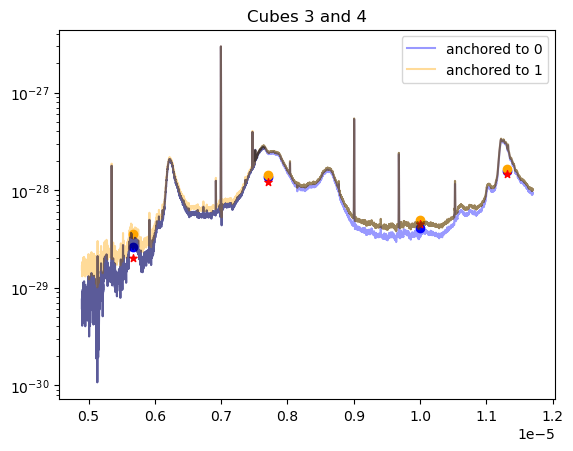

Stitching RIGHT: anchor → file 1
Combined spectrum: 7.5106502288836055e-06 -- 1.79787500470411e-05
filter goes from 6.2080000000000005e-06 to 9.329e-06, but provided Fnu array goes from 7.5106502288836055e-06 to 1.79787500470411e-05
Stitching LEFT: file 0 → anchor
Combined spectrum: 7.5106502288836055e-06 -- 1.79787500470411e-05
filter goes from 6.2080000000000005e-06 to 9.329e-06, but provided Fnu array goes from 7.5106502288836055e-06 to 1.79787500470411e-05


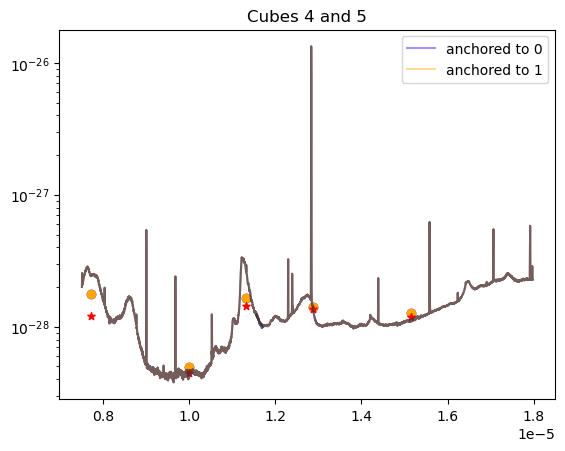

Stitching RIGHT: anchor → file 1
A total of 13 were detected within 1.25 arcsec in Arm2_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs
Combined spectrum: 1.1551250190706922e-05 -- 2.870100085856393e-05
filter goes from 1.1086e-05 to 1.4613e-05, but provided Fnu array goes from 1.1551250190706922e-05 to 2.870100085856393e-05
A total of 13 were detected within 1.25 arcsec in Arm2_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs
Stitching LEFT: file 0 → anchor
Combined spectrum: 1.1551250190706922e-05 -- 2.870100085856393e-05
filter goes from 1.1086e-05 to 1.4613e-05, but provided Fnu array goes from 1.1551250190706922e-05 to 2.870100085856393e-05
A total of 13 were detected within 1.25 arcsec in Arm2_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs


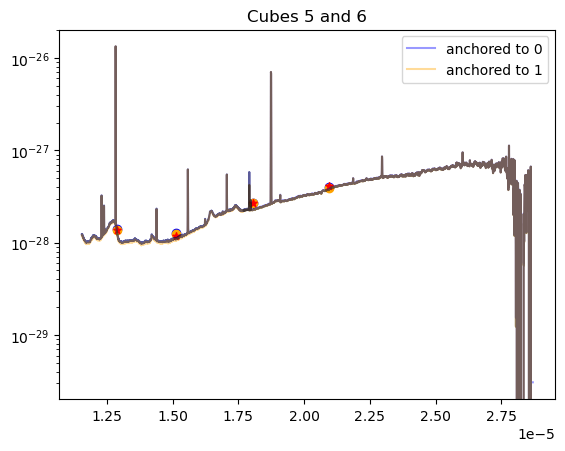

In [9]:
#Comparing adjacent cubes for location 2

for idx in range(6):
    loc = locations[2]
    files = full_raw_ifu_files_loc1
    phot_wl = loc2_photo_wls
    phot_flux = loc2_photo_fluxes
    data = stitch_spectra(files[idx:idx+2], loc, radius, replace_negatives = False, anchor_idx = 0)
    plt.plot(data['wavelength'], data['intensity'], alpha = 0.4, color = 'blue', label = 'anchored to 0')
    min_wl = min(data['wavelength'])
    max_wl = max(data['wavelength'])
    photo_indices = [i for i, x in enumerate(phot_wl) if min_wl < x < max_wl]
    photo_x = [phot_wl[i] for i in photo_indices]
    synth_y = []
    for filter_name in [photo_filter_names[i] for i in photo_indices]:
        filter_wl, filter_trans = get_filter_data(filter_name)
        synth_y.append(get_Fnu_transmission(data['intensity'], data['wavelength'], filter_trans, filter_wl, warnings = True))

    photo_y = np.array([phot_flux[x] for x in range(len(phot_flux)) if (min_wl < phot_wl[x] < max_wl)])
    synth_y = np.array(synth_y)
    

    plt.scatter(photo_x, synth_y, marker = 'o', color = 'blue')
    data = stitch_spectra(files[idx:idx+2], loc, radius, replace_negatives = False, anchor_idx = 1)
    plt.plot(data['wavelength'], data['intensity'], alpha = 0.4, color = 'orange', label = 'anchored to 1')
    synth_y = []
    for filter_name in [photo_filter_names[i] for i in photo_indices]:
        filter_wl, filter_trans = get_filter_data(filter_name)
        synth_y.append(get_Fnu_transmission(data['intensity'], data['wavelength'], filter_trans, filter_wl, warnings = True))

    synth_y = np.array(synth_y)
    plt.scatter(photo_x, synth_y, marker = 'o', color = 'orange')

    data = get_IFU_spectrum(files[idx], loc, radius)
    plt.plot(data['wavelength'], data['intensity'], color = 'black', alpha = 0.4)
    
    
    data = get_IFU_spectrum(files[idx+1], loc, radius)
    plt.plot(data['wavelength'], data['intensity'], color = 'black', alpha = 0.4)
    plt.scatter(photo_x, photo_y, marker = "*", color = 'red', s = 30)

    plt.yscale('log')
    plt.legend()
    plt.title(f'Cubes {idx} and {idx+1}')
    plt.show()


A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Stitching RIGHT: anchor → file 1
A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 9.703180286160204e-07 to 3.169970021757762e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Stitching LEFT: file 0 → anchor
A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g140m-f100lp_s3d.fits over 1447 WLs
Combined spectrum: 9.703180286160204e-07 -- 3.169970021757762e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 9.703180286160204e-07 to 3.169970021757762e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g140m-f100lp_s3d.fits over 1447 WL

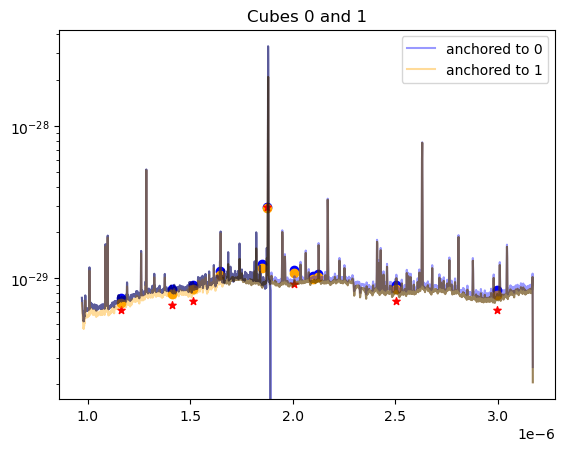

A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Stitching RIGHT: anchor → file 1
A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Combined spectrum: 1.6605299666407517e-06 -- 5.269494898093397e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Stitching LEFT: file 0 → anchor
A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
Combined spectrum: 1.6605299666407517e-06 -- 5.269494898093397e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g235m-f170lp_s3d.fits over 1425 WLs
A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g395m-f290lp_s3d.fits over 1341 WLs


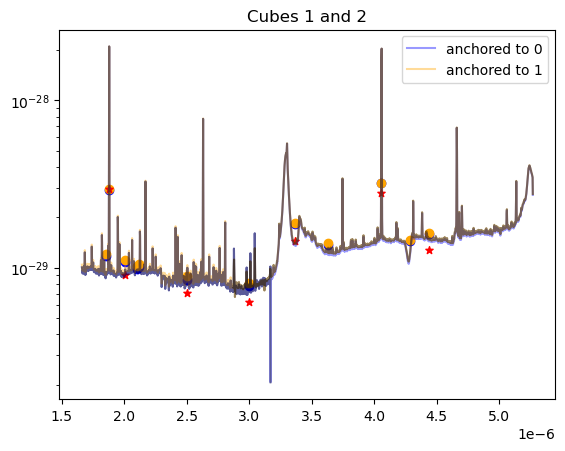

A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Stitching RIGHT: anchor → file 1
Combined spectrum: 2.870894885563757e-06 -- 7.650000025896587e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 2.870894885563757e-06 to 7.650000025896587e-06
Stitching LEFT: file 0 → anchor
A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g395m-f290lp_s3d.fits over 1341 WLs
Combined spectrum: 2.870894885563757e-06 -- 7.650000025896587e-06
filter goes from 2.70111e-06 to 3.31457e-06, but provided Fnu array goes from 2.870894885563757e-06 to 7.650000025896587e-06
A total of 1 were detected within 1.25 arcsec in jw03435-o006_t010_nirspec_g395m-f290lp_s3d.fits over 1341 WLs


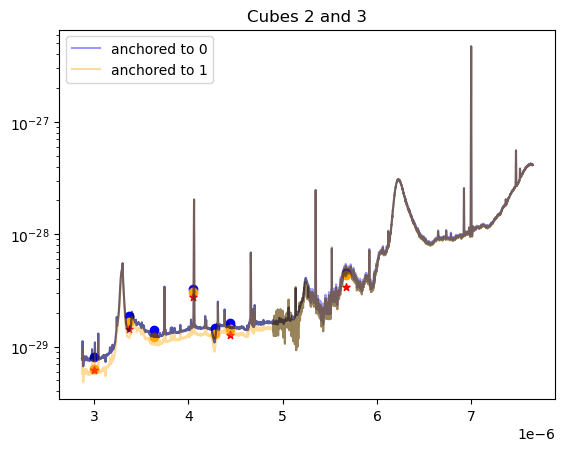

Stitching RIGHT: anchor → file 1
Combined spectrum: 4.9004000953573265e-06 -- 1.1700550240289882e-05
filter goes from 4.753e-06 to 6.696e-06, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05
filter goes from 1.0251e-05 to 1.2229000000000001e-05, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05
Stitching LEFT: file 0 → anchor
Combined spectrum: 4.9004000953573265e-06 -- 1.1700550240289882e-05
filter goes from 4.753e-06 to 6.696e-06, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05
filter goes from 1.0251e-05 to 1.2229000000000001e-05, but provided Fnu array goes from 4.9004000953573265e-06 to 1.1700550240289882e-05


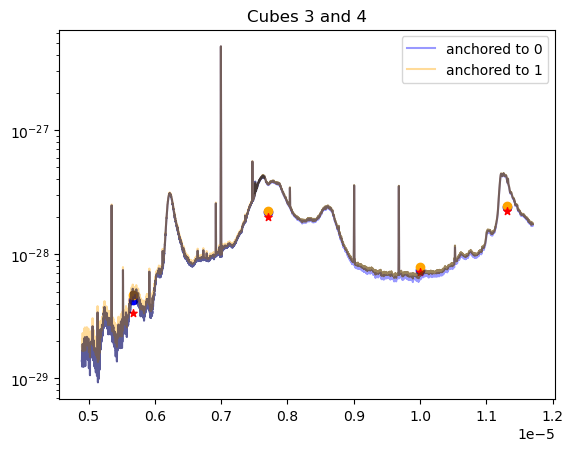

Stitching RIGHT: anchor → file 1
Combined spectrum: 7.5106502288836055e-06 -- 1.79787500470411e-05
filter goes from 6.2080000000000005e-06 to 9.329e-06, but provided Fnu array goes from 7.5106502288836055e-06 to 1.79787500470411e-05
Stitching LEFT: file 0 → anchor
Combined spectrum: 7.5106502288836055e-06 -- 1.79787500470411e-05
filter goes from 6.2080000000000005e-06 to 9.329e-06, but provided Fnu array goes from 7.5106502288836055e-06 to 1.79787500470411e-05


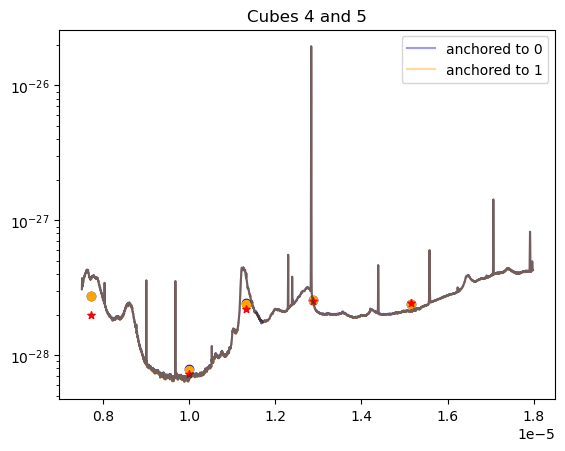

Stitching RIGHT: anchor → file 1
A total of 13 were detected within 1.25 arcsec in Arm3_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs
Combined spectrum: 1.1551250190706922e-05 -- 2.870100085856393e-05
filter goes from 1.1086e-05 to 1.4613e-05, but provided Fnu array goes from 1.1551250190706922e-05 to 2.870100085856393e-05
A total of 13 were detected within 1.25 arcsec in Arm3_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs
Stitching LEFT: file 0 → anchor
Combined spectrum: 1.1551250190706922e-05 -- 2.870100085856393e-05
filter goes from 1.1086e-05 to 1.4613e-05, but provided Fnu array goes from 1.1551250190706922e-05 to 2.870100085856393e-05
A total of 13 were detected within 1.25 arcsec in Arm3_Level3_ch4-shortmediumlong_s3d.fits over 1834 WLs


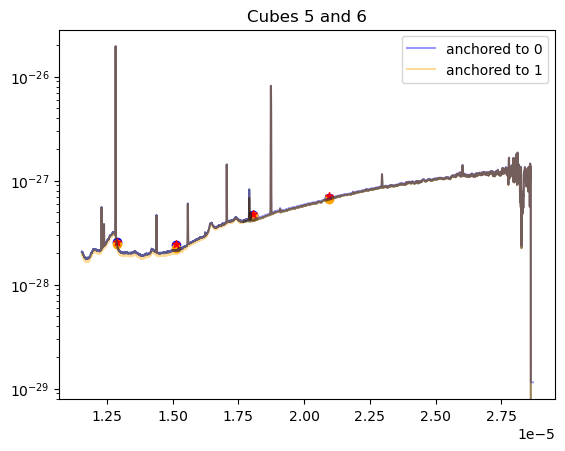

In [10]:
#Comparing adjacent cubes for location 3

for idx in range(6):
    loc = locations[3]
    files = full_raw_ifu_files_loc3
    phot_wl = loc3_photo_wls
    phot_flux = loc3_photo_fluxes
    data = stitch_spectra(files[idx:idx+2], loc, radius, replace_negatives = False, anchor_idx = 0)
    plt.plot(data['wavelength'], data['intensity'], alpha = 0.4, color = 'blue', label = 'anchored to 0')
    min_wl = min(data['wavelength'])
    max_wl = max(data['wavelength'])
    photo_indices = [i for i, x in enumerate(phot_wl) if min_wl < x < max_wl]
    photo_x = [phot_wl[i] for i in photo_indices]
    synth_y = []
    for filter_name in [photo_filter_names[i] for i in photo_indices]:
        filter_wl, filter_trans = get_filter_data(filter_name)
        synth_y.append(get_Fnu_transmission(data['intensity'], data['wavelength'], filter_trans, filter_wl, warnings = True))

    photo_y = np.array([phot_flux[x] for x in range(len(phot_flux)) if (min_wl < phot_wl[x] < max_wl)])
    synth_y = np.array(synth_y)
    

    plt.scatter(photo_x, synth_y, marker = 'o', color = 'blue')
    data = stitch_spectra(files[idx:idx+2], loc, radius, replace_negatives = False, anchor_idx = 1)
    plt.plot(data['wavelength'], data['intensity'], alpha = 0.4, color = 'orange', label = 'anchored to 1')
    synth_y = []
    for filter_name in [photo_filter_names[i] for i in photo_indices]:
        filter_wl, filter_trans = get_filter_data(filter_name)
        synth_y.append(get_Fnu_transmission(data['intensity'], data['wavelength'], filter_trans, filter_wl, warnings = True))

    synth_y = np.array(synth_y)
    plt.scatter(photo_x, synth_y, marker = 'o', color = 'orange')

    data = get_IFU_spectrum(files[idx], loc, radius)
    plt.plot(data['wavelength'], data['intensity'], color = 'black', alpha = 0.4)
    
    
    data = get_IFU_spectrum(files[idx+1], loc, radius)
    plt.plot(data['wavelength'], data['intensity'], color = 'black', alpha = 0.4)
    plt.scatter(photo_x, photo_y, marker = "*", color = 'red', s = 30)

    plt.yscale('log')
    plt.legend()
    plt.title(f'Cubes {idx} and {idx+1}')
    plt.show()


[Text(0, 0, 'F115W'),
 Text(1, 0, 'F140M'),
 Text(2, 0, 'F150W'),
 Text(3, 0, 'F164N'),
 Text(4, 0, 'F182M'),
 Text(5, 0, 'F187N'),
 Text(6, 0, 'F200W'),
 Text(7, 0, 'F210M'),
 Text(8, 0, 'F212N'),
 Text(9, 0, 'F250M'),
 Text(10, 0, 'F300M'),
 Text(11, 0, 'F335M'),
 Text(12, 0, 'F360M'),
 Text(13, 0, 'F405N'),
 Text(14, 0, 'F430M'),
 Text(15, 0, 'F444W'),
 Text(16, 0, 'F560W'),
 Text(17, 0, 'F770W'),
 Text(18, 0, 'F1000W'),
 Text(19, 0, 'F1130W'),
 Text(20, 0, 'F1280W'),
 Text(21, 0, 'F1500W'),
 Text(22, 0, 'F1800W'),
 Text(23, 0, 'F2100W')]

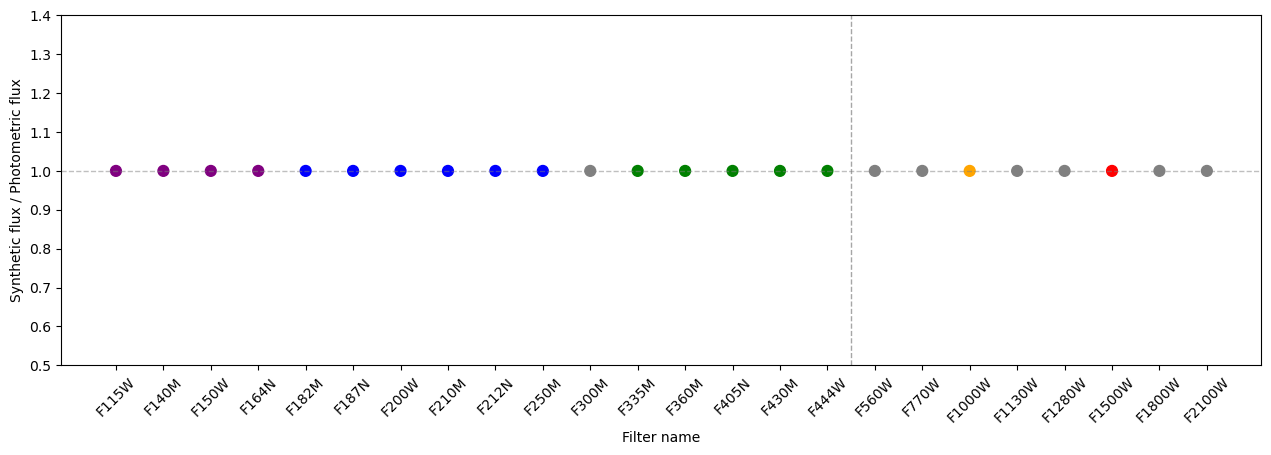

In [58]:
fig = plt.figure(figsize=(12, 10))
y_data = [1] *24

colors_for_cubes = ['purple', 'blue', 'green', 'yellow', 'orange', 'red', 'pink']

point_colors = []
for f in filter_names:
    fmin, fmax = get_filter_wl_range(f)

    covering_cubes = []
    for i, (cmin, cmax) in enumerate(zip(short_bounds, long_bounds)):
        if (fmin >= cmin) and (fmax <= cmax):
            covering_cubes.append(i)

    # Assign color
    if len(covering_cubes) == 1:
        point_colors.append(colors_for_cubes[covering_cubes[0]])
    elif len(covering_cubes) > 1:
        point_colors.append('black')
    else:
        point_colors.append('gray')  # fallback if no cube covers it

# Now plot with per-point colors
ax_scat = fig.add_axes((0.05, 0.05, 1, 0.35))
ax_scat.scatter(filter_names, y_data, marker="o", c=point_colors, s=60)
ax_scat.set_xlabel("Filter name")
ax_scat.set_ylabel("Synthetic flux / Photometric flux")
ax_scat.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax_scat.axvline(x=15.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax_scat.set_ylim(0.5, 1.4)
ax_scat.set_xticklabels(ax_scat.get_xticklabels(), rotation=45)


[Text(0, 0, 'F115W'),
 Text(1, 0, 'F140M'),
 Text(2, 0, 'F150W'),
 Text(3, 0, 'F164N'),
 Text(4, 0, 'F182M'),
 Text(5, 0, 'F187N'),
 Text(6, 0, 'F200W'),
 Text(7, 0, 'F210M'),
 Text(8, 0, 'F212N'),
 Text(9, 0, 'F250M'),
 Text(10, 0, 'F300M'),
 Text(11, 0, 'F335M'),
 Text(12, 0, 'F360M'),
 Text(13, 0, 'F405N'),
 Text(14, 0, 'F430M'),
 Text(15, 0, 'F444W'),
 Text(16, 0, 'F560W'),
 Text(17, 0, 'F770W'),
 Text(18, 0, 'F1000W'),
 Text(19, 0, 'F1130W'),
 Text(20, 0, 'F1280W'),
 Text(21, 0, 'F1500W'),
 Text(22, 0, 'F1800W'),
 Text(23, 0, 'F2100W')]

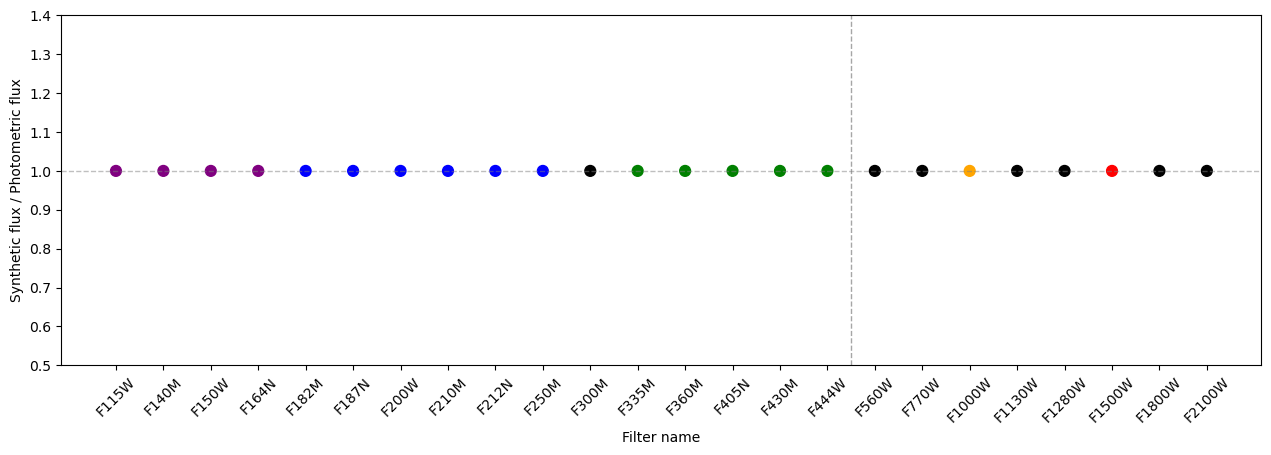

In [61]:
fig = plt.figure(figsize=(12, 10))
y_data = [1] * 24

colors_for_cubes = ['purple', 'blue', 'green', 'yellow', 'orange', 'red', 'pink']

point_colors = []
for f in filter_names:
    fmin, fmax = get_filter_wl_range(f)

    fully_covering = []
    partially_covering = []

    for i, (cmin, cmax) in enumerate(zip(short_bounds, long_bounds)):
        # Full coverage
        if (fmin >= cmin) and (fmax <= cmax):
            fully_covering.append(i)
        # Partial overlap
        elif (fmax > cmin) and (fmin < cmax):
            partially_covering.append(i)

    # Decide color
    if len(fully_covering) == 1:
        point_colors.append(colors_for_cubes[fully_covering[0]])
    elif len(partially_covering) == 2:
        point_colors.append('black')
    else:
        point_colors.append('white')

# Now plot with per-point colors
ax_scat = fig.add_axes((0.05, 0.05, 1, 0.35))
ax_scat.scatter(filter_names, y_data, marker="o", c=point_colors, s=60)
ax_scat.set_xlabel("Filter name")
ax_scat.set_ylabel("Synthetic flux / Photometric flux")
ax_scat.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax_scat.axvline(x=15.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax_scat.set_ylim(0.5, 1.4)
ax_scat.set_xticklabels(ax_scat.get_xticklabels(), rotation=45)


In [62]:
for file in full_raw_ifu_files_loc0:
    wl = SpectralCube.read(file, hdu = 'SCI').spectral_axis
    print(wl[0], wl[-1])

0.9703180286160203 um 1.8899740453634868 um
1.6605299666407518 um 3.169970021757762 um
2.8708948855637573 um 5.269494898093397 um
4.900400095357327 um 7.650000025896587 um
7.5106502288836055 um 11.700550240289882 um
11.551250190706922 um 17.9787500470411 um
17.70300076296553 um 28.70100085856393 um


In [66]:
get_filter_wl_range("F187N")

(<Quantity 1.8342e-06 m>, <Quantity 1.9132e-06 m>)

In [67]:
for file in full_raw_ifu_files_loc0:
    cube = SpectralCube.read(file, hdu = 'SCI').spectral_axis
    print(cube[0],cube[-1])

0.9703180286160203 um 1.8899740453634868 um
1.6605299666407518 um 3.169970021757762 um
2.8708948855637573 um 5.269494898093397 um
4.900400095357327 um 7.650000025896587 um
7.5106502288836055 um 11.700550240289882 um
11.551250190706922 um 17.9787500470411 um
17.70300076296553 um 28.70100085856393 um
